In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, FancyArrowPatch

FIG_DPI = 600
FONT_FAMILY = "Arial"

plt.rcParams.update({
    "figure.dpi": FIG_DPI, "savefig.dpi": FIG_DPI,
    "font.family": FONT_FAMILY,
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "pdf.fonttype": 42,   # TrueType -> editable text in Illustrator
    "ps.fonttype": 42,
})


In [2]:
# prep_gene_token_inputs_min.py
import os, glob, json
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Iterable, Union, Any
import numpy as np
import pandas as pd
import scipy.sparse as sp
from concurrent.futures import ThreadPoolExecutor, as_completed
import pyarrow.parquet as pq

# ======================================================
# 0) Minimal token map structures (CLS presence optional)
# ======================================================

@dataclass(frozen=True)
class GeneTokenRef:
    gene_id: str
    cell_id: str
    shard_id: str
    line_idx: int  # row index within the shard's cell_gene_pairs order

@dataclass
class TokenMaps:
    gene_pos_by_cell: Dict[str, List[GeneTokenRef]]
    cell_order: List[str]
    shard_ids: List[str]

# =========================================
# 1) Token maps loader (reads shard folders)
# =========================================

def _is_cls_token(tok: str) -> bool:
    return tok in {"<cls>", "<CLS>", "CLS", "cls"}

def _parse_line(line: str, sep: Optional[str], cell_col: int, token_col: int) -> Tuple[str, str]:
    parts = line.rstrip("\n").split(sep) if sep is not None else line.split()
    if len(parts) <= max(cell_col, token_col):
        raise ValueError(f"Malformed line: {line!r}")
    return parts[cell_col], parts[token_col]

def _list_shard_dirs(root_dir: str) -> List[str]:
    out = []
    for path in sorted(glob.glob(os.path.join(root_dir, "*"))):
        if os.path.isdir(path) and os.path.exists(os.path.join(path, "cell_gene_pairs.txt")):
            out.append(path)
    if not out:
        raise FileNotFoundError(f"No shard subfolders with cell_gene_pairs.txt under: {root_dir}")
    return out

def token_batch_loader(
    root_dir: str,
    *,
    sep: Optional[str] = None,
    has_header: bool = False,
    cell_col: int = 0,
    token_col: int = 1,
) -> TokenMaps:
    """Builds per-cell lists of gene-token references (line indices within each shard)."""
    shard_dirs = _list_shard_dirs(root_dir)
    shard_ids: List[str] = []
    gene_pos_by_cell: Dict[str, List[GeneTokenRef]] = {}
    cells_with_cls: set = set()

    for shard_dir in shard_dirs:
        shard_id = os.path.basename(os.path.normpath(shard_dir))
        shard_ids.append(shard_id)
        txt_path = os.path.join(shard_dir, "cell_gene_pairs.txt")

        with open(txt_path, "r") as f:
            line_num = -1
            for raw in f:
                if not raw.strip():
                    continue
                line_num += 1
                if has_header and line_num == 0:
                    continue
                try:
                    cell_id, token_str = _parse_line(raw, sep=sep, cell_col=cell_col, token_col=token_col)
                except ValueError:
                    continue

                if _is_cls_token(token_str):
                    cells_with_cls.add(cell_id)
                else:
                    rec = GeneTokenRef(gene_id=token_str, cell_id=cell_id, shard_id=shard_id, line_idx=line_num)
                    gene_pos_by_cell.setdefault(cell_id, []).append(rec)

    # Keep only cells that had a CLS sentinel (safety)
    for cid in list(gene_pos_by_cell.keys()):
        if cid not in cells_with_cls:
            gene_pos_by_cell.pop(cid, None)

    cell_order = sorted(gene_pos_by_cell.keys())
    return TokenMaps(
        gene_pos_by_cell=gene_pos_by_cell,
        cell_order=cell_order,
        shard_ids=sorted(set(shard_ids)),
    )

# =========================================
# 2) Gene-token SAE latents loader (parallel)
# =========================================

def _discover_feature_columns(parquet_path: str, max_features: Optional[int]) -> List[str]:
    """Return sorted numeric-like column names as strings: ['0','1',...]."""
    pf = pq.ParquetFile(parquet_path)
    cols = [c for c in pf.schema.names if c not in {"cell_id", "gene_id"}]
    numlike = [str(c) for c in cols if (isinstance(c, (int, np.integer)) or str(c).isdigit())]
    if not numlike:
        raise ValueError(f"{parquet_path}: no numeric latent columns named 0..K-1")
    numlike = sorted(numlike, key=lambda x: int(x))
    if max_features is not None:
        numlike = numlike[:int(max_features)]
    return numlike

def _load_one_shard_gene(
    shard_dir: str,
    reqs: List[Tuple[int, int]],  # [(global_row_idx, line_idx_in_shard), ...]
    file_name: str,
    feat_cols_sorted: List[str],
):
    pq_path = os.path.join(shard_dir, file_name)
    table = pq.ParquetFile(pq_path).read(columns=feat_cols_sorted)
    arr = table.to_pandas(use_threads=True).to_numpy(dtype=np.float32, copy=False)

    gidxs = np.fromiter((g for g, _ in reqs), dtype=np.int64, count=len(reqs))
    lidxs = np.fromiter((l for _, l in reqs), dtype=np.int64, count=len(reqs))
    data = arr[lidxs, :]  # (len(reqs), F)
    return gidxs, data

def features_batch_loader_gene(
    token_maps: TokenMaps,
    root_dir: str,
    file_name: str = "sae_latents.parquet",
    *,
    max_workers: int = 8,
    sample_cells_frac: float = 0.20,                 # keep 20% of cells by default
    sample_cells_ids: Optional[Iterable[str]] = None,
    sample_random_state: Optional[int] = 1337,
    max_features: Optional[int] = 512,               # cap latent dims
    dtype: np.dtype = np.float16,                    # fp16 halves memory
) -> Dict[str, np.ndarray]:
    """Fast gene-token latent loader.
    Returns:
      H_SAE_tokens: (M_sub, p_sub)
      gene_ids_all, cell_ids_all, shard_ids_all, line_idx_all: (M_sub,)
    """
    # choose cells
    all_cells = np.array(token_maps.cell_order, dtype=object)
    if sample_cells_ids is not None:
        keep_cells = np.array([c for c in all_cells if c in set(sample_cells_ids)], dtype=object)
    elif sample_cells_frac < 1.0:
        rng = np.random.RandomState(sample_random_state)
        k = max(1, int(round(sample_cells_frac * len(all_cells))))
        keep_cells = np.sort(rng.choice(all_cells, size=k, replace=False))
    else:
        keep_cells = all_cells

    print(f"[features_batch_loader_gene] Keeping {len(keep_cells)}/{len(all_cells)} cells "
          f"(~{100*len(keep_cells)/len(all_cells):.1f}%).")

    # ordered gene-tokens from kept cells
    token_refs: List[GeneTokenRef] = []
    keep_set = set(map(str, keep_cells))
    for cid in token_maps.cell_order:
        if cid in keep_set:
            token_refs.extend(token_maps.gene_pos_by_cell.get(cid, []))
    if not token_refs:
        raise RuntimeError("No gene tokens found after cell subsampling.")

    # group by shard with new global indices
    by_shard: Dict[str, List[Tuple[int, int]]] = {}
    for gidx, ref in enumerate(token_refs):
        by_shard.setdefault(ref.shard_id, []).append((gidx, ref.line_idx))

    # shard paths
    shard_paths = {os.path.basename(p): p for p in glob.glob(os.path.join(root_dir, "*")) if os.path.isdir(p)}
    missing = [sid for sid in by_shard if sid not in shard_paths]
    if missing:
        raise FileNotFoundError(f"Missing shard dirs under {root_dir}: {missing}")

    # discover feature columns once
    any_sid = next(iter(by_shard))
    feat_cols_sorted = _discover_feature_columns(
        os.path.join(shard_paths[any_sid], file_name),
        max_features=max_features
    )

    # lazy allocate after first shard returns
    M_sub = len(token_refs)
    H_SAE_tokens = None

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = {
            ex.submit(_load_one_shard_gene, shard_paths[sid], reqs, file_name, feat_cols_sorted): sid
            for sid, reqs in by_shard.items()
        }
        for fut in as_completed(futs):
            gidxs, data = fut.result()
            if H_SAE_tokens is None:
                F = data.shape[1]
                est_gb = M_sub * F * np.dtype(dtype).itemsize / 1e9
                print(f"Allocating H_SAE_tokens: shape=({M_sub:,}, {F}), dtype={dtype}, ~{est_gb:.2f} GB")
                H_SAE_tokens = np.empty((M_sub, F), dtype=dtype)
            if data.dtype != H_SAE_tokens.dtype:
                data = data.astype(H_SAE_tokens.dtype, copy=False)
            H_SAE_tokens[gidxs] = data

    # provenance arrays
    gene_ids_all  = np.fromiter((r.gene_id for r in token_refs), dtype=object, count=M_sub)
    cell_ids_all  = np.fromiter((r.cell_id for r in token_refs), dtype=object, count=M_sub)

    return dict(
        H_SAE_tokens=H_SAE_tokens,
        gene_ids_all=gene_ids_all,
        cell_ids_all=cell_ids_all,
    )

# ====================================
# 3) Gene-token alignment to AnnData
# ====================================

def audit_and_align_gene_tokens(
    *,
    adata,
    H_SAE_tokens: Optional[np.ndarray],
    gene_ids_all: np.ndarray,
    cell_ids_all: np.ndarray,
    adata_gene_id_col: Optional[str] = None,      # None => use var_names; else a column in adata.var
    cell_id_column_in_obs: Optional[str] = None,  # None => use obs_names
    strict_intersection: bool = True,
    log1p_gene_count: bool = True,
    celltype_col: str = "author_cell_type",
    verbose: bool = True,
) -> Dict[str, Any]:
    """Align gene-token rows to AnnData; returns aligned arrays and covariates."""

    M_all = len(gene_ids_all)

    # cells
    if cell_id_column_in_obs is None:
        obs_ids = adata.obs_names.astype(str).to_numpy()
    else:
        if cell_id_column_in_obs not in adata.obs.columns:
            raise KeyError(f"`cell_id_column_in_obs='{cell_id_column_in_obs}'` not in adata.obs.columns")
        obs_ids = adata.obs[cell_id_column_in_obs].astype(str).to_numpy()

    cell_idx_all = pd.Index(obs_ids).get_indexer(np.asarray(cell_ids_all, dtype=str))  # -1 = missing

    # genes
    if adata_gene_id_col is None:
        # fallback to var_names only when no column is specified
        var_ids = adata.var_names.astype(str).to_numpy()
    else:
        if adata_gene_id_col not in adata.var.columns:
            raise KeyError(f"`adata_gene_id_col='{adata_gene_id_col}'` not in adata.var.columns")
        var_ids = adata.var[adata_gene_id_col].astype(str).to_numpy()

    gene_idx_all = pd.Index(var_ids).get_indexer(np.asarray(gene_ids_all, dtype=str))  # -1 = missing

    keep_mask = (cell_idx_all >= 0) & (gene_idx_all >= 0) if strict_intersection else np.ones(M_all, bool)
    if verbose:
        print("=== Gene-token Alignment Audit ===")
        print(f"Total tokens: {M_all}")
        print(f"Kept tokens (strict intersection): {int(keep_mask.sum())}")

    # slice to kept
    cell_idx_token  = cell_idx_all[keep_mask]
    gene_idx_token  = gene_idx_all[keep_mask]
    gene_ids_token  = np.asarray(gene_ids_all, dtype=str)[keep_mask]
    cell_ids_token  = np.asarray(cell_ids_all, dtype=str)[keep_mask]

    H_SAE = None
    if H_SAE_tokens is not None:
        if H_SAE_tokens.shape[0] != M_all:
            raise ValueError(f"H_SAE_tokens rows ({H_SAE_tokens.shape[0]}) != total tokens ({M_all})")
        H_SAE = H_SAE_tokens[keep_mask]

    # covariates
    if sp.issparse(adata.X):
        vals = np.asarray(adata.X[cell_idx_token, gene_idx_token]).ravel()
        libsize = np.asarray(adata.X.sum(axis=1)).ravel()
    else:
        X = np.asarray(adata.X)
        vals = X[cell_idx_token, gene_idx_token]
        libsize = X.sum(axis=1)
    GENECOUNT_TOKEN = np.log1p(vals) if log1p_gene_count else vals
    LIBSIZE_TOKEN   = libsize[cell_idx_token]

    if celltype_col not in adata.obs:
        raise KeyError(f"adata.obs['{celltype_col}'] not found.")
    CELLTYPE_TOKEN = adata.obs[celltype_col].astype(str).to_numpy()[cell_idx_token]

    return dict(
        H_SAE=H_SAE,                                   # (M, p) or None
        gene_ids_token=gene_ids_token,                 # (M,)
        cell_ids_token=cell_ids_token,                 # (M,)
        cell_idx_token=cell_idx_token,                 # (M,)
        gene_idx_token=gene_idx_token,                 # (M,)
        GENECOUNT_TOKEN=GENECOUNT_TOKEN,               # (M,)
        LIBSIZE_TOKEN=LIBSIZE_TOKEN,                   # (M,)
        CELLTYPE_TOKEN=CELLTYPE_TOKEN,                 # (M,)
        keep_mask=keep_mask,                           # (M_all,)
    )

# ====================================
# 4) Targets & sanity helpers (used)
# ====================================

def build_targets_from_gene_sets(
    gene_ids_token: np.ndarray,
    gene_sets: Dict[str, Iterable[str]],
    *,
    min_positives: int = 30,
) -> Dict[str, np.ndarray]:
    M = len(gene_ids_token)
    targets = {}
    for label, members in gene_sets.items():
        member_set = set(map(str, members))
        y = np.fromiter((1 if g in member_set else 0 for g in gene_ids_token), dtype=np.int8, count=M)
        if y.sum() >= min_positives:
            targets[label] = y
    return targets

def assert_alignment_shapes(
    H_SAE: Optional[np.ndarray],
    gene_ids_token: np.ndarray,
    CELLTYPE_TOKEN: np.ndarray,
    GENECOUNT_TOKEN: np.ndarray,
    TARGETS_DICT: Dict[str, np.ndarray],
):
    M = len(gene_ids_token)
    if H_SAE is not None:
        assert H_SAE.shape[0] == M, f"H_SAE rows {H_SAE.shape[0]} != {M}"
    assert CELLTYPE_TOKEN.shape[0] == M, f"CELLTYPE_TOKEN len {CELLTYPE_TOKEN.shape[0]} != {M}"
    assert GENECOUNT_TOKEN.shape[0] == M, f"GENECOUNT_TOKEN len {GENECOUNT_TOKEN.shape[0]} != {M}"
    for k, v in TARGETS_DICT.items():
        assert v.shape == (M,), f"Target {k} shape {v.shape} != {(M,)}"

# ====================================
# 5) Orchestrator (end-to-end wrapper)
# ====================================

def prepare_inputs_for_gene_token_layer(
    *,
    gene_id_root: str,            # path with shards & cell_gene_pairs.txt
    layer_root: str,              # path with shards & sae_latents.parquet
    adata,                        # AnnData
    adata_gene_id_col: Optional[str] = None,       # None => auto (prefers var_names)
    cell_id_column_in_obs: Optional[str] = None,   # None => obs_names
    celltype_col: str = "author_cell_type",
    min_positives: int = 30,
    gene_sets: Optional[Dict[str, Iterable[str]]] = None,
    file_name: str = "sae_latents.parquet",
    log1p_gene_count: bool = True,
    verbose: bool = True,
    # memory knobs
    sample_cells_frac: float = 0.20,
    sample_cells_ids: Optional[Iterable[str]] = None,
    sample_random_state: Optional[int] = 1337,
    max_features: Optional[int] = 512,
    dtype: np.dtype = np.float16,
    max_workers: int = 4,
) -> Dict[str, Any]:
    # 0) token maps
    token_maps = token_batch_loader(gene_id_root)
    print(f"Cells in token_maps: {len(token_maps.cell_order)}")

    # 1) latents (subsample cells; cap features; fp16)
    gt = features_batch_loader_gene(
        token_maps,
        root_dir=layer_root,
        file_name=file_name,
        sample_cells_frac=sample_cells_frac,
        sample_cells_ids=sample_cells_ids,
        sample_random_state=sample_random_state,
        max_workers=max_workers,
        max_features=max_features,
        dtype=dtype,
    )

    print(gt)

    # 2) gene-ID namespace: auto if None or 'index'
    # (We try var_names first; if poor overlap and a symbol-like column exists, you can pass it explicitly.)
    # effective_gene_id_col = None if (adata_gene_id_col in [None, "index", "var_names"]) else adata_gene_id_col
    # if verbose and adata_gene_id_col in ["index", "var_names"]:
    #     print("[ID select] Using var_names (explicit 'index'/'var_names' treated as var_names).")
    effective_gene_id_col = 'index'

    print(adata_gene_id_col)
    # 3) align
    aligned = audit_and_align_gene_tokens(
        adata=adata,
        H_SAE_tokens=gt["H_SAE_tokens"],
        gene_ids_all=gt["gene_ids_all"],
        cell_ids_all=gt["cell_ids_all"],
        adata_gene_id_col=adata_gene_id_col,
        cell_id_column_in_obs=cell_id_column_in_obs,
        strict_intersection=True,
        log1p_gene_count=log1p_gene_count,
        celltype_col=celltype_col,
        verbose=verbose,
    )

    kept = int(aligned["keep_mask"].sum())
    if verbose:
        print(f"Kept tokens after align: {kept}")

    if kept == 0:
        raise RuntimeError(
            "Alignment kept 0 tokens. If your token gene IDs are symbols, pass e.g. adata_gene_id_col='symbol'."
        )

    # 4) targets (optional)
    TARGETS_DICT = {}
    if gene_sets is not None:
        TARGETS_DICT = build_targets_from_gene_sets(aligned["gene_ids_token"], gene_sets, min_positives=min_positives)

    # 5) sanity
    assert_alignment_shapes(
        aligned["H_SAE"],
        aligned["gene_ids_token"],
        aligned["CELLTYPE_TOKEN"],
        aligned["GENECOUNT_TOKEN"],
        TARGETS_DICT,
    )

    return dict(
        H_SAE=aligned["H_SAE"],
        gene_ids_token=aligned["gene_ids_token"],
        cell_ids_token=aligned["cell_ids_token"],
        cell_idx_token=aligned["cell_idx_token"],
        gene_idx_token=aligned["gene_idx_token"],
        GENECOUNT_TOKEN=aligned["GENECOUNT_TOKEN"],
        LIBSIZE_TOKEN=aligned["LIBSIZE_TOKEN"],
        CELLTYPE_TOKEN=aligned["CELLTYPE_TOKEN"],
        TARGETS_DICT=TARGETS_DICT,
        keep_mask=aligned["keep_mask"],
        meta=dict(
            layer_root=layer_root,
            gene_id_root=gene_id_root,
            adata_gene_id_col=(effective_gene_id_col or "var_names"),
            cell_id_column_in_obs=cell_id_column_in_obs,
            celltype_col=celltype_col,
            min_positives=min_positives,
            log1p_gene_count=log1p_gene_count,
            sample_cells_frac=sample_cells_frac,
            max_features=max_features,
            dtype=str(dtype),
        ),
    )

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

# 0) Load AnnData
adata = sc.read_h5ad("/maiziezhou_lab2/yunfei/Projects/FM_temp/InterPLM/interplm/ge_shards/cosmx_human_lung_sec8.h5ad")

# 1) Build gene sets (rows=index=concept name, columns=gene IDs; 0/1 membership)
gene_concept_df = pd.read_csv(
    "/maiziezhou_lab2/yunfei/Projects/interpTFM/gprofiler_annotation/gene_concepts.csv",
    index_col=0
)
concept_header = pd.read_csv(
    "/maiziezhou_lab2/yunfei/Projects/interpTFM/gprofiler_annotation/gprofiler_gene_concepts_columns.txt",
    header=None, index_col=0
)
gene_concept_df.index = concept_header.index

min_positives = 30

gene_concept_df = (
    gene_concept_df.copy()
    .rename(index=concept_header.squeeze().astype(str).to_dict())
)
gene_concept_df.index   = gene_concept_df.index.astype(str)
gene_concept_df.columns = gene_concept_df.columns.astype(str)
gene_concept_df = gene_concept_df.apply(pd.to_numeric, errors="coerce").fillna(0).astype(int).clip(0, 1)

if not gene_concept_df.index.is_unique:
    gene_concept_df = gene_concept_df.groupby(level=0).max()

gene_sets = {
    str(concept): set(row.index[row.astype(bool)])
    for concept, row in gene_concept_df.iterrows()
    if int(row.sum()) >= min_positives
}

# 2) Prepare one SAE layer (e.g., layer_4)
prep = prepare_inputs_for_gene_token_layer(
    gene_id_root="/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/gene_ids",
    layer_root="/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4",
    adata=adata,
    adata_gene_id_col='index',        
    sample_cells_frac=0.2,
    max_features=None,             # keep all latent dims
    dtype=np.float16,
    max_workers=4,
    verbose=True,
    gene_sets=gene_sets,
)

# 3) Canonical outputs
H_SAE           = prep["H_SAE"]            # (M, p)
gene_ids_token  = prep["gene_ids_token"]   # (M,)
CELLTYPE_TOKEN  = prep["CELLTYPE_TOKEN"]   # (M,)
GENECOUNT_TOKEN = prep["GENECOUNT_TOKEN"]  # (M,)
TARGETS_DICT    = prep["TARGETS_DICT"]     # dict[label -> (M,)]

# Optionals
LIBSIZE_TOKEN   = prep["LIBSIZE_TOKEN"]
cell_idx_token  = prep["cell_idx_token"]
gene_idx_token  = prep["gene_idx_token"]

Cells in token_maps: 81236
[features_batch_loader_gene] Keeping 16247/81236 cells (~20.0%).
Allocating H_SAE_tokens: shape=(6,106,399, 4096), dtype=<class 'numpy.float16'>, ~50.02 GB
{'H_SAE_tokens': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16), 'gene_ids_all': array(['ABL1', 'ACVR2A', 'ADGRG2', ..., '<pad>', '<pad>', '<pad>'],
      dtype=object), 'cell_ids_all': array(['1000_10-7', '1000_10-7', '1000_10-7', ..., '9_5-5', '9_5-5',
       '9_5-5'], dtype=object)}
index
=== Gene-token Alignment Audit ===
Total tokens: 6106399
Kept tokens (strict intersection): 2170804
Kept tokens after align: 2170804


In [ ]:
# # ---------- quick cache for prepare_inputs_for_gene_token_layer ----------
# import os, json, hashlib
# import numpy as np

# CACHE_DIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/cached"
# os.makedirs(CACHE_DIR, exist_ok=True)

# def _cache_key(**kwargs) -> str:
#     """
#     Build a filename-safe key from the *inputs that change outputs*.
#     Include paths and the main knobs; exclude big objects like adata.
#     """
#     # Keep ordering stable for hashing
#     keys = [
#         ("gene_id_root", kwargs.get("gene_id_root")),
#         ("layer_root", kwargs.get("layer_root")),
#         ("adata_gene_id_col", kwargs.get("adata_gene_id_col")),
#         ("cell_id_column_in_obs", kwargs.get("cell_id_column_in_obs")),
#         ("celltype_col", kwargs.get("celltype_col", "author_cell_type")),
#         ("min_positives", kwargs.get("min_positives", 30)),
#         ("sample_cells_frac", kwargs.get("sample_cells_frac", 1.0)),
#         ("max_features", kwargs.get("max_features")),
#         ("dtype", str(kwargs.get("dtype", np.float16))),
#         ("log1p_gene_count", kwargs.get("log1p_gene_count", True)),
#         ("file_name", kwargs.get("file_name", "sae_latents.parquet")),
#         # you can add more knobs if you flip them often
#     ]
#     s = json.dumps(keys, sort_keys=True)
#     h = hashlib.sha1(s.encode("utf-8")).hexdigest()[:12]
#     return f"prep_cache_{h}"

# def save_prep_cache(cache_dir, key, prep, extra_meta=None):
#     arr_path = os.path.join(cache_dir, key + ".npz")
#     meta_path = os.path.join(cache_dir, key + ".json")

#     # Pack TARGETS_DICT into flat arrays with a prefix
#     targets = prep.get("TARGETS_DICT", {}) or {}
#     npz_payload = {
#         "H_SAE":           prep["H_SAE"],
#         "gene_ids_token":  np.asarray(prep["gene_ids_token"], dtype=object),
#         "cell_ids_token":  np.asarray(prep["cell_ids_token"], dtype=object),
#         "cell_idx_token":  np.asarray(prep["cell_idx_token"]),
#         "gene_idx_token":  np.asarray(prep["gene_idx_token"]),
#         "GENECOUNT_TOKEN": np.asarray(prep["GENECOUNT_TOKEN"]),
#         "LIBSIZE_TOKEN":   np.asarray(prep["LIBSIZE_TOKEN"]),
#         "CELLTYPE_TOKEN":  np.asarray(prep["CELLTYPE_TOKEN"], dtype=object),
#     }
#     for lab, vec in targets.items():
#         npz_payload[f"TARGET__{lab}"] = np.asarray(vec)

#     np.savez_compressed(arr_path, **npz_payload)

#     meta = {
#         "version": 1,
#         "targets_labels": list(targets.keys()),
#         "prep_meta": prep.get("meta", {}),
#         "extra_meta": extra_meta or {},
#     }
#     with open(meta_path, "w") as f:
#         json.dump(meta, f, indent=2)
#     print(f"[cache] saved arrays → {arr_path}\n[cache] saved meta   → {meta_path}")

# def load_prep_cache(cache_dir, key):
#     arr_path = os.path.join(cache_dir, key + ".npz")
#     meta_path = os.path.join(cache_dir, key + ".json")
#     if not (os.path.exists(arr_path) and os.path.exists(meta_path)):
#         return None

#     data = np.load(arr_path, allow_pickle=True)
#     with open(meta_path, "r") as f:
#         meta = json.load(f)

#     # Reconstruct TARGETS_DICT from prefixed entries
#     targets = {}
#     for lab in meta.get("targets_labels", []):
#         targets[lab] = data[f"TARGET__{lab}"]

#     prep = dict(
#         H_SAE           = data["H_SAE"],
#         gene_ids_token  = data["gene_ids_token"],
#         cell_ids_token  = data["cell_ids_token"],
#         cell_idx_token  = data["cell_idx_token"],
#         gene_idx_token  = data["gene_idx_token"],
#         GENECOUNT_TOKEN = data["GENECOUNT_TOKEN"],
#         LIBSIZE_TOKEN   = data["LIBSIZE_TOKEN"],
#         CELLTYPE_TOKEN  = data["CELLTYPE_TOKEN"],
#         TARGETS_DICT    = targets,
#         keep_mask       = None,             # not needed downstream; omit to keep file small
#         meta            = meta.get("prep_meta", {}),
#     )
#     print(f"[cache] loaded from {arr_path}")
#     return prep

# # ---------- usage ----------
# # 1) Build the cache key from the exact knobs you pass to the orchestrator:
# key = _cache_key(
#     gene_id_root="/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/gene_ids",
#     layer_root="/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4",
#     adata_gene_id_col="index",
#     sample_cells_frac=0.20,
#     max_features=None,
#     dtype=np.float16,
#     file_name="sae_latents.parquet",
#     celltype_col="author_cell_type",
#     min_positives=30,
# )

# # 2) Try to load; otherwise compute and save
# prep = load_prep_cache(CACHE_DIR, key)
# if prep is None:
#     prep = prepare_inputs_for_gene_token_layer(
#         gene_id_root="/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/gene_ids",
#         layer_root="/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4",
#         adata=adata,
#         adata_gene_id_col="index",
#         sample_cells_frac=0.20,
#         max_features=None,
#         dtype=np.float16,
#         max_workers=4,
#         verbose=True,
#         gene_sets=gene_sets,
#     )
#     save_prep_cache(CACHE_DIR, key, prep, extra_meta={"note": "cosmx_lung_sec8 layer_4"})

# # 3) Canonical outputs (same as before)
# H_SAE           = prep["H_SAE"]
# gene_ids_token  = prep["gene_ids_token"]
# CELLTYPE_TOKEN  = prep["CELLTYPE_TOKEN"]
# GENECOUNT_TOKEN = prep["GENECOUNT_TOKEN"]
# TARGETS_DICT    = prep["TARGETS_DICT"]
# LIBSIZE_TOKEN   = prep["LIBSIZE_TOKEN"]
# cell_idx_token  = prep["cell_idx_token"]
# gene_idx_token  = prep["gene_idx_token"]

# celltype

In [4]:
import numpy as np
import pandas as pd

def celltype_specificity(
    H_SAE,
    CELLTYPE_TOKEN,
    top_k_types=3,
    min_tokens_per_type=200,
    *,
    sample_frac=0.10,               # use 10% of tokens by default
    per_type_cap=None,              # stratified cap per type, e.g., 200_000
    random_state=1337,
    sample_idx=None,                # reuse the SAME token indices as gene-token analysis
    skeptical=True,
    verbose=True,
):
    """
    Per-neuron specificity over CELL TYPES using a subsample of tokens.
    Returns:
      out_df: DataFrame[neuron, ct_gini, ct_kl, top_types, top_type_means, ... + diagnostics]
      mean_mat: DataFrame [cell_types_used x P]
      sample_idx: ndarray of chosen token rows
      diag: dict with diagnostics
    """
    rng = np.random.RandomState(random_state)
    M, P = H_SAE.shape
    c_all = np.asarray(CELLTYPE_TOKEN).astype(object)

    # ---- 0) choose token subsample indices ----
    if sample_idx is None:
        if per_type_cap is not None:
            t_unique_all, inv_all = np.unique(c_all, return_inverse=True)
            counts_all = np.bincount(inv_all)
            want_per_type = np.ceil(counts_all * float(sample_frac)).astype(int)
            want_per_type = np.minimum(want_per_type, int(per_type_cap))
            pick = []
            for tid, need in enumerate(want_per_type):
                if need <= 0:
                    continue
                loc = np.where(inv_all == tid)[0]
                if loc.size == 0:
                    continue
                if need >= loc.size:
                    pick.append(loc)
                else:
                    pick.append(rng.choice(loc, size=need, replace=False))
            sample_idx = np.concatenate(pick) if len(pick) else np.array([], dtype=int)
        else:
            k = max(1, int(np.ceil(sample_frac * M)))
            sample_idx = rng.choice(np.arange(M), size=k, replace=False)

    sample_idx = np.asarray(sample_idx, dtype=int)
    if sample_idx.size == 0:
        raise ValueError("celltype_specificity: subsample is empty; adjust sample_frac/per_type_cap.")

    # ---- 1) restrict to subsample ----
    H = H_SAE[sample_idx]
    c_sub = c_all[sample_idx]

    # ---- 2) encode categories and (later) drop tiny types ----
    t_unique, inv = np.unique(c_sub, return_inverse=True)  # inv in 0..(len(t_unique)-1)
    counts = np.bincount(inv)

    # Decide which type IDs to keep
    keep_type_ids = np.where(counts >= min_tokens_per_type)[0]
    if keep_type_ids.size == 0:
        if verbose:
            print(f"[celltype_specificity] No types with ≥{min_tokens_per_type} tokens; relaxing threshold.")
        # Relax threshold: keep all types present
        keep_type_ids = np.arange(counts.size, dtype=int)

    # Build a compact remapping old_id -> new_id in 0..T-1
    T = keep_type_ids.size
    remap = np.full(t_unique.size, fill_value=-1, dtype=int)
    remap[keep_type_ids] = np.arange(T, dtype=int)

    # Keep only rows assigned to kept types and remap inv to compact IDs
    mask = remap[inv] >= 0
    H = H[mask]
    inv_kept = remap[inv[mask]]

    # Safety check (prevents IndexError in np.add.at)
    if inv_kept.size == 0:
        raise ValueError("[celltype_specificity] No tokens remain after keeping types. Try lowering min_tokens_per_type.")
    if inv_kept.max() >= T or inv_kept.min() < 0:
        raise RuntimeError("[celltype_specificity] Internal remap error; inv_kept out of bounds.")

    kept_type_names = t_unique[keep_type_ids].astype(object)

    # ---- 3) aggregate means per type ----
    sums = np.zeros((T, P), dtype=np.float64)
    np.add.at(sums, inv_kept, H)
    denom = np.bincount(inv_kept, minlength=T).reshape(T, 1).astype(np.float64)
    means = sums / np.maximum(denom, 1.0)  # (T x P)

    # ---- 4) probs across types; Gini/KL ----
    def _safe_probs_colwise(MEANS):
        s = MEANS.sum(axis=0, keepdims=True)
        s[s <= 0] = 1.0
        P_ = MEANS / s
        P_[P_ < 0] = 0
        return P_

    def gini_from_probs_colwise(P_):
        Tn, Pn = P_.shape
        order = np.argsort(P_, axis=0)
        cols = np.arange(Pn)
        P_sorted = P_[order, cols]
        weights = (np.arange(Tn, 0, -1) / Tn).reshape(Tn, 1)
        gini = 1.0 - 2.0 * np.sum(weights * P_sorted, axis=0)
        return gini

    def kl_to_uniform_colwise(P_):
        Tn = P_.shape[0]
        u = 1.0 / Tn
        P_clipped = np.clip(P_, 1e-12, 1.0)
        P_clipped /= P_clipped.sum(axis=0, keepdims=True)
        return np.sum(P_clipped * (np.log(P_clipped) - np.log(u)), axis=0)

    probs = _safe_probs_colwise(np.clip(means, a_min=0, a_max=None))
    ct_gini = gini_from_probs_colwise(probs)
    ct_kl   = kl_to_uniform_colwise(probs)

    # ---- 5) top-k types & discriminative summaries ----
    top_types = []
    top_means = []
    sum_cols = means.sum(axis=0) + 1e-12
    top1 = means.max(axis=0)
    top1_mass = (top1 / sum_cols)
    support_size = (means > 0).sum(axis=0)
    with np.errstate(divide='ignore', invalid='ignore'):
        Pclip = np.clip(probs, 1e-12, 1.0)
        entropy = -np.sum(Pclip * np.log(Pclip), axis=0)

    for j in range(P):
        order = np.argsort(-means[:, j])[:top_k_types]
        top_types.append(kept_type_names[order].tolist())
        top_means.append(means[order, j].tolist())

    out = pd.DataFrame({
        "neuron": np.arange(P, dtype=int),
        "ct_gini": ct_gini,
        "ct_kl": ct_kl,
        "top_types": top_types,
        "top_type_means": top_means,
        "top1_mass": top1_mass,
        "support_size": support_size,
        "entropy": entropy,
        "n_types_used": T,
        "n_tokens_used": H.shape[0],
        "sample_frac": float(sample_frac),
        "per_type_cap": per_type_cap if per_type_cap is not None else np.nan,
    }).sort_values(["top1_mass", "ct_gini", "ct_kl"], ascending=[False, False, False]).reset_index(drop=True)

    mean_mat = pd.DataFrame(means, index=kept_type_names, columns=np.arange(P))

    # ---- 6) skeptical diagnostics ----
    diag = {}
    warnings = []
    if skeptical:
        exp_kl = float(np.log(T))
        exp_gini = 1.0 - 2.0 / float(T)
        kl_diff = np.abs(ct_kl - exp_kl)
        gini_diff = np.abs(ct_gini - exp_gini)
        frac_kl_near_delta = float((kl_diff < 5e-3).mean())
        frac_gini_near_delta = float((gini_diff < 5e-3).mean())
        stats = lambda v: (float(np.min(v)), float(np.median(v)), float(np.percentile(v, 90)), float(np.max(v)))
        diag = {
            "T": int(T),
            "P": int(P),
            "top1_mass_stats": stats(top1_mass),
            "support_size_stats": stats(support_size.astype(float)),
            "entropy_stats": stats(entropy),
            "frac_kl_near_logT": frac_kl_near_delta,
            "frac_gini_near_1_minus_2_over_T": frac_gini_near_delta,
            "expected_kl_logT": exp_kl,
            "expected_gini_1_minus_2_over_T": exp_gini,
        }
        if frac_kl_near_delta > 0.5 and frac_gini_near_delta > 0.5:
            warnings.append(
                f"[celltype_specificity] {100*frac_kl_near_delta:.1f}% neurons have KL≈log(T) and "
                f"{100*frac_gini_near_delta:.1f}% have Gini≈1−2/T (delta-like across cell types)."
            )
        if verbose:
            print(f"[celltype_specificity] T={T}, P={P}")
            print(" top1_mass (min/med/p90/max):", diag["top1_mass_stats"])
            print(" support_size (min/med/p90/max):", diag["support_size_stats"])
            print(f" frac KL≈log(T): {frac_kl_near_delta:.3f}, frac Gini≈1−2/T: {frac_gini_near_delta:.3f}")
            if warnings:
                for w in warnings:
                    print(" WARNING:", w)

    return out, mean_mat, sample_idx, {"warnings": warnings, **diag}

celltype_df, ct_means, _, ct_diag = celltype_specificity(
    H_SAE, CELLTYPE_TOKEN,
    sample_frac=0.20,
    sample_idx=None,     # ← reuse EXACT tokens
    min_tokens_per_type=200,
    skeptical=True, verbose=True,
)

[celltype_specificity] T=17, P=4096
 top1_mass (min/med/p90/max): (0.0, 0.4411050666419101, 0.9937547697180567, 0.9999999998540532)
 support_size (min/med/p90/max): (0.0, 5.0, 14.0, 17.0)
 frac KL≈log(T): 0.096, frac Gini≈1−2/T: 0.125


In [12]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.dpi": FIG_DPI, "savefig.dpi": FIG_DPI,
    "font.family": FONT_FAMILY,
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "pdf.fonttype": 42,   # TrueType -> editable text in Illustrator
    "ps.fonttype": 42,
})

SAVE_DIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/figures_ct"
os.makedirs(SAVE_DIR, exist_ok=True)


def ct_fig1_selectivity(celltype_df, save_path):
    top1 = np.asarray(celltype_df["top1_mass"].values, float)
    gini = np.asarray(celltype_df["ct_gini"].values, float)
    kl   = np.asarray(celltype_df["ct_kl"].values, float)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    # Left: top1 mass violin + box
    ax = axes[0]
    parts = ax.violinplot(top1, showextrema=False, showmeans=False)
    for pc in parts['bodies']:
        pc.set_facecolor("0.85"); pc.set_edgecolor("0.25"); pc.set_alpha(1.0)
    ax.boxplot([top1], positions=[1], widths=0.15, vert=True,
               boxprops=dict(color="0.25"), whiskerprops=dict(color="0.25"),
               capprops=dict(color="0.25"), medianprops=dict(color="0.25"))
    med = np.nanmedian(top1)
    ax.axhline(med, ls="--", lw=1.2, color="0.35")
    ax.text(1.08, med, f"median={med:.2f}", va="center", color="0.35")
    ax.set_xticks([1]); ax.set_xticklabels(["neurons"])
    ax.set_ylabel("top1 mass per neuron")
    ax.set_title("Neuron selectivity (top1 mass)")

    # Right: Gini vs KL
    ax = axes[1]
    ax.scatter(gini, kl, s=12, color="0.25", alpha=0.75)
    ax.set_xlabel("Gini (probability over cell types)")
    ax.set_ylabel("KL to uniform")
    ax.set_title("Selectivity shape: Gini vs KL")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.close(fig)

ct_fig1_selectivity(celltype_df, f"{SAVE_DIR}/CT_Fig1_selectivity.pdf")

def ct_fig2_heatmap(celltype_df, ct_means, top_n_neurons=30, k_types=3, save_path=None):
    # celltype_df is sorted by selectivity already in the earlier function
    keep_neurons = celltype_df["neuron"].astype(int).values[:top_n_neurons]
    # Build a (type × neuron) matrix with only each neuron’s top-k types kept
    means = ct_means.iloc[:, keep_neurons].copy()   # rows=cell types, cols=neurons
    mask = np.zeros_like(means.values, dtype=bool)
    for col_j, n_id in enumerate(keep_neurons):
        col_vals = means.iloc[:, col_j].values
        topK = np.argsort(-col_vals)[:k_types]
        mask[topK, col_j] = True
    shown = means.where(mask, other=0.0)

    fig, ax = plt.subplots(figsize=(9.5, 9))
    im = ax.imshow(shown.values, aspect="auto", cmap="Greys", vmin=0, vmax=np.nanmax(shown.values) or 1)
    ax.set_yticks(np.arange(shown.shape[0]))
    ax.set_yticklabels(shown.index, fontsize=8)
    ax.set_xticks(np.arange(shown.shape[1]))
    ax.set_xticklabels(keep_neurons, rotation=80, ha="right", fontsize=7)
    ax.set_title(f"Top-{top_n_neurons} neurons × top-{k_types} cell types")
    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label("mean activation (normalized per neuron)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close(fig)

ct_fig2_heatmap(celltype_df, ct_means, top_n_neurons=30, k_types=3,
                save_path=f"{SAVE_DIR}/CT_Fig2_top30xTop3_heatmap.pdf")

def ct_fig3_specialization(ct_means, save_path):
    # For each neuron (column), find the argmax cell type
    top_type_idx = np.argmax(ct_means.values, axis=0)
    types = ct_means.index.to_numpy()
    counts = pd.Series(types[top_type_idx]).value_counts().sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(counts.index, counts.values, color="0.25", alpha=0.9)
    ax.set_xlabel("# neurons with this top-1 cell type")
    ax.set_title("Neuron specialization by cell type (top-1 per neuron)")
    for i, v in enumerate(counts.values):
        ax.text(v + 0.5, i, str(v), va="center", fontsize=9)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.close(fig)

ct_fig3_specialization(ct_means, f"{SAVE_DIR}/CT_Fig3_specialization_bar.pdf")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Reuse your existing SAVE_DIR
# SAVE_DIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/cached"
# os.makedirs(SAVE_DIR, exist_ok=True)

def _ct_selectivity_once(H_SAE, CELLTYPE_TOKEN, sample_idx, min_tokens_per_type):
    """Run celltype_specificity once with fixed sample_idx; return per-neuron top1 and gini."""
    df, _, _, _ = celltype_specificity(
        H_SAE, CELLTYPE_TOKEN,
        sample_frac=1.0,               # we pass explicit sample_idx, so frac is ignored
        sample_idx=sample_idx,
        min_tokens_per_type=min_tokens_per_type,
        skeptical=False, verbose=False,
    )
    return df["top1_mass"].to_numpy(dtype=float), df["ct_gini"].to_numpy(dtype=float)

def ct_perm_control(
    H_SAE, CELLTYPE_TOKEN, sample_idx, *,
    n_perm=200, min_tokens_per_type=200, seed=17,
    save_path=f"{SAVE_DIR}/CT_perm_control.pdf"
):
    rng = np.random.default_rng(seed)

    # Observed stats (fixed sample)
    obs_top1, obs_gini = _ct_selectivity_once(
        H_SAE, CELLTYPE_TOKEN, sample_idx, min_tokens_per_type
    )

    # Null stats by shuffling cell-type labels *within the sampled tokens*
    null_top1_all = []
    null_gini_all = []
    CELLTYPE_TOKEN = np.asarray(CELLTYPE_TOKEN).copy()

    for _ in range(n_perm):
        shuffled = CELLTYPE_TOKEN.copy()
        # permute labels on the chosen tokens only (preserves label counts in the sample)
        shuffled[sample_idx] = shuffled[sample_idx][rng.permutation(len(sample_idx))]
        t1, gg = _ct_selectivity_once(
            H_SAE, shuffled, sample_idx, min_tokens_per_type
        )
        null_top1_all.append(t1)
        null_gini_all.append(gg)

    null_top1_all = np.concatenate(null_top1_all) if len(null_top1_all) else np.array([])
    null_gini_all = np.concatenate(null_gini_all) if len(null_gini_all) else np.array([])

    # ---- Plot (two panels) ----
    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 300,
        "font.family": "Arial",
        "axes.titlesize": 14, "axes.labelsize": 12,
        "xtick.labelsize": 10, "ytick.labelsize": 10
    })
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

    # Left: top1 mass null violin + box; overlay observed as black points and median line
    ax = axes[0]
    if null_top1_all.size:
        parts = ax.violinplot(null_top1_all, showextrema=False, showmeans=False)
        for pc in parts['bodies']:
            pc.set_facecolor("0.80"); pc.set_edgecolor("0.25"); pc.set_alpha(1.0)
        ax.boxplot([null_top1_all], positions=[1], widths=0.15, vert=True,
                   boxprops=dict(color="0.25"), whiskerprops=dict(color="0.25"),
                   capprops=dict(color="0.25"), medianprops=dict(color="0.25"))
    # overlay observed per-neuron points (jittered)
    jitter = (rng.random(len(obs_top1)) - 0.5) * 0.05 + 1.0
    ax.scatter(jitter, obs_top1, s=10, color="0.05", alpha=0.8, zorder=3)
    ax.axhline(np.nanmedian(obs_top1), ls="--", lw=1.2, color="0.2")
    ax.set_xticks([1]); ax.set_xticklabels(["null"])
    ax.set_ylabel("top1 mass per neuron")
    ax.set_title(f"Permutation control (n={n_perm}) — top1 mass")

    # Right: Gini null violin + observed points
    ax = axes[1]
    if null_gini_all.size:
        parts = ax.violinplot(null_gini_all, showextrema=False, showmeans=False)
        for pc in parts['bodies']:
            pc.set_facecolor("0.80"); pc.set_edgecolor("0.25"); pc.set_alpha(1.0)
        ax.boxplot([null_gini_all], positions=[1], widths=0.15, vert=True,
                   boxprops=dict(color="0.25"), whiskerprops=dict(color="0.25"),
                   capprops=dict(color="0.25"), medianprops=dict(color="0.25"))
    jitter = (rng.random(len(obs_gini)) - 0.5) * 0.05 + 1.0
    ax.scatter(jitter, obs_gini, s=10, color="0.05", alpha=0.8, zorder=3)
    ax.axhline(np.nanmedian(obs_gini), ls="--", lw=1.2, color="0.2")
    ax.set_xticks([1]); ax.set_xticklabels(["null"])
    ax.set_ylabel("Gini per neuron (over cell types)")
    ax.set_title(f"Permutation control (n={n_perm}) — Gini")

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.close(fig)

    # Quick numeric summary you can log
    summary = {
        "obs_top1_median": float(np.nanmedian(obs_top1)),
        "null_top1_median": float(np.nanmedian(null_top1_all)) if null_top1_all.size else np.nan,
        "obs_gini_median": float(np.nanmedian(obs_gini)),
        "null_gini_median": float(np.nanmedian(null_gini_all)) if null_gini_all.size else np.nan,
    }
    print("CT permutation control summary:", summary)
    return summary

# ---- run with the SAME token subset you used (shared_idx) ----
# If you want to reuse the exact tokens from the gene-token analysis, pass shared_idx there.
sample_idx_for_null = None
if sample_idx_for_null is None:
    # fall back to the same selection the celltype_specificity used; re-compute to capture indices
    _, _, sample_idx_for_null, _ = celltype_specificity(
        H_SAE, CELLTYPE_TOKEN, sample_frac=0.20, sample_idx=None,
        min_tokens_per_type=200, skeptical=False, verbose=False
    )

_ = ct_perm_control(
    H_SAE, CELLTYPE_TOKEN,
    sample_idx=sample_idx_for_null,
    n_perm=200, min_tokens_per_type=200,
    save_path=f"{SAVE_DIR}/CT_perm_control.pdf"
)

# gene

In [5]:
import numpy as np
import pandas as pd

def _safe_probs(x):
    x = np.asarray(x, float)
    s = x.sum()
    if s <= 0:
        # uniform fallback to avoid degenerate KL
        return np.ones_like(x) / len(x)
    return x / s

def gini_from_probs(p):
    # p is a probability vector
    p = np.sort(np.clip(np.asarray(p, float), 0, 1))
    n = len(p)
    if n == 0: return np.nan
    cum = np.cumsum(p)
    # Gini for discrete distribution (Lorenz-based)
    # G = 1 - 2 * sum_{i=1..n} (n+1-i)/n * p_(i)
    weights = (np.arange(n, 0, -1) / n)
    return 1.0 - 2.0 * np.sum(weights * p)

def kl_to_uniform(p):
    p = np.asarray(p, float)
    n = len(p)
    if n == 0: return np.nan
    p = np.clip(p, 1e-12, 1.0)
    p = p / p.sum()
    u = 1.0 / n
    return float(np.sum(p * (np.log(p) - np.log(u))))

# =========================
# Gene-token specificity (with diagnostics)
# =========================
import numpy as np
import pandas as pd

def gene_token_specificity(
    H_SAE,
    gene_ids_token,
    top_k_genes=5,
    min_tokens_per_gene=10,
    max_genes=20000,
    *,
    sample_frac=0.10,              # use ~10% tokens by default
    per_gene_cap=None,             # e.g., 200 to cap tokens per gene (stratified)
    random_state=1337,
    sample_idx=None,               # reuse an explicit token subset
    skeptical=True,                # run diagnostics & warnings
    verbose=True,                  # print brief status
):
    rng = np.random.RandomState(random_state)
    M, P = H_SAE.shape
    genes_all = np.asarray(gene_ids_token)

    # ---- 0) choose token subsample indices ----
    if sample_idx is None:
        if per_gene_cap is not None:
            g_unique, inv = np.unique(genes_all, return_inverse=True)
            counts = np.bincount(inv)
            want_per_gene = np.ceil(counts * float(sample_frac)).astype(int)
            want_per_gene = np.minimum(want_per_gene, int(per_gene_cap))
            pick = []
            for gid, need in enumerate(want_per_gene):
                if need <= 0:
                    continue
                loc = np.where(inv == gid)[0]
                if len(loc) == 0:
                    continue
                if need >= len(loc):
                    pick.append(loc)
                else:
                    pick.append(rng.choice(loc, size=need, replace=False))
            sample_idx = np.concatenate(pick) if len(pick) else np.array([], dtype=int)
        else:
            k = max(1, int(np.ceil(sample_frac * M)))
            sample_idx = rng.choice(np.arange(M), size=k, replace=False)
    sample_idx = np.asarray(sample_idx, dtype=int)
    if sample_idx.size == 0:
        raise ValueError("gene_token_specificity: subsample is empty; adjust sample_frac/per_gene_cap.")

    # ---- 1) restrict to subsample ----
    H = H_SAE[sample_idx]
    genes_sub = genes_all[sample_idx]

    # ---- 2) cap number of genes to keep memory reasonable ----
    g_unique, inv = np.unique(genes_sub, return_inverse=True)
    if len(g_unique) > max_genes:
        counts = np.bincount(inv)
        top_idx = np.argsort(-counts)[:max_genes]
        keep_set = set(g_unique[top_idx])
        keep_mask = np.array([g in keep_set for g in genes_sub])
        H = H[keep_mask]
        genes_sub = genes_sub[keep_mask]
        g_unique, inv = np.unique(genes_sub, return_inverse=True)

    # ---- 3) drop genes with too few tokens after subsampling ----
    counts = np.bincount(inv)
    keep_gene_ids = np.where(counts >= min_tokens_per_gene)[0]
    if keep_gene_ids.size == 0:
        raise ValueError(f"gene_token_specificity: no genes have ≥{min_tokens_per_gene} tokens after subsampling.")
    mask = np.isin(inv, keep_gene_ids)
    H = H[mask]
    inv = inv[mask]

    # ---- 4) aggregate means per gene (fast & memory-safe) ----
    G = keep_gene_ids.size
    sums = np.zeros((G, P), dtype=np.float64)
    np.add.at(sums, inv, H)
    denom = np.bincount(inv, minlength=G).reshape(G, 1).astype(np.float64)
    means = sums / np.maximum(denom, 1.0)  # (G x P)

    # ---- 5) convert to probability over genes → Gini & KL ----
    def _safe_probs_colwise(MEANS):
        s = MEANS.sum(axis=0, keepdims=True)
        s[s <= 0] = 1.0
        P_ = MEANS / s
        P_[P_ < 0] = 0
        return P_

    def gini_from_probs_colwise(P_):
        G, Pn = P_.shape
        order = np.argsort(P_, axis=0)           # ascending
        cols = np.arange(Pn)
        P_sorted = P_[order, cols]
        weights = (np.arange(G, 0, -1) / G).reshape(G, 1)
        return 1.0 - 2.0 * np.sum(weights * P_sorted, axis=0)

    def kl_to_uniform_colwise(P_):
        G = P_.shape[0]
        u = 1.0 / G
        P_clipped = np.clip(P_, 1e-12, 1.0)
        P_clipped /= P_clipped.sum(axis=0, keepdims=True)
        return np.sum(P_clipped * (np.log(P_clipped) - np.log(u)), axis=0)

    probs = _safe_probs_colwise(np.clip(means, a_min=0, a_max=None))
    gene_gini = gini_from_probs_colwise(probs)
    gene_kl   = kl_to_uniform_colwise(probs)

    # ---- 6) top-k genes per neuron + discriminative summaries ----
    kept_gene_names = g_unique[keep_gene_ids].astype(object)
    top_genes, top_means = [], []
    sum_cols = means.sum(axis=0) + 1e-12
    top1 = means.max(axis=0)
    top1_mass = (top1 / sum_cols)
    support_size = (means > 0).sum(axis=0)
    with np.errstate(divide='ignore', invalid='ignore'):
        Pclip = np.clip(probs, 1e-12, 1.0)
        entropy = -np.sum(Pclip * np.log(Pclip), axis=0)

    for j in range(P):
        order = np.argsort(-means[:, j])[:top_k_genes]
        top_genes.append(kept_gene_names[order].tolist())
        top_means.append(means[order, j].tolist())

    out = pd.DataFrame({
        "neuron": np.arange(P, dtype=int),
        "gene_gini": gene_gini,
        "gene_kl": gene_kl,
        "top_genes": top_genes,
        "top_gene_means": top_means,
        "top1_mass": top1_mass,
        "support_size": support_size,
        "entropy": entropy,
        "n_genes_used": G,
        "n_tokens_used": H.shape[0],
        "sample_frac": float(sample_frac),
        "per_gene_cap": per_gene_cap if per_gene_cap is not None else np.nan,
    }).sort_values(["top1_mass", "gene_gini", "gene_kl"], ascending=[False, False, False]).reset_index(drop=True)

    mean_mat = pd.DataFrame(means, index=kept_gene_names, columns=np.arange(P))

    # ---- 7) skeptical diagnostics ----
    diag = {}
    warnings = []
    if skeptical:
        exp_kl = float(np.log(G))
        exp_gini = 1.0 - 2.0 / float(G)
        kl_diff = np.abs(gene_kl - exp_kl)
        gini_diff = np.abs(gene_gini - exp_gini)
        frac_kl_near_delta = float((kl_diff < 5e-3).mean())
        frac_gini_near_delta = float((gini_diff < 5e-3).mean())

        stats = lambda v: (float(np.min(v)), float(np.median(v)),
                           float(np.percentile(v, 90)), float(np.max(v)))
        diag = {
            "G": int(G), "P": int(P),
            "top1_mass_stats": stats(top1_mass),
            "support_size_stats": stats(support_size.astype(float)),
            "entropy_stats": stats(entropy),
            "frac_kl_near_logG": frac_kl_near_delta,
            "frac_gini_near_1_minus_2_over_G": frac_gini_near_delta,
            "expected_kl_logG": exp_kl,
            "expected_gini_1_minus_2_over_G": exp_gini,
        }
        if frac_kl_near_delta > 0.5 and frac_gini_near_delta > 0.5:
            warnings.append(
                f"[gene_token_specificity] {100*frac_kl_near_delta:.1f}% neurons have KL≈log(G) "
                f"and {100*frac_gini_near_delta:.1f}% have Gini≈1−2/G (delta-like). "
                "Many neurons behave as near one-gene detectors on this sample."
            )
        if (top1_mass > 0.99).mean() > 0.5:
            warnings.append("[gene_token_specificity] >50% neurons have >99% mass on a single gene.")
        if verbose:
            print(f"[gene_token_specificity] G={G}, P={P}")
            print(" top1_mass (min/med/p90/max):", diag["top1_mass_stats"])
            print(" support_size (min/med/p90/max):", diag["support_size_stats"])
            print(f" frac KL≈log(G): {frac_kl_near_delta:.3f}, frac Gini≈1−2/G: {frac_gini_near_delta:.3f}")
            for w in warnings:
                print(" WARNING:", w)

    return out, mean_mat, sample_idx, {"warnings": warnings, **diag}

In [6]:
# Always subsample ~10%; optionally cap to at most 200 tokens per gene
gene_df, g_means, shared_idx, gene_diag = gene_token_specificity(
    H_SAE, gene_ids_token,
    top_k_genes=10,
    min_tokens_per_gene=20,
    sample_frac=0.10,
    per_gene_cap=200,             # helps avoid domination by super-abundant genes
    random_state=42,
    skeptical=True, verbose=True,
)

print("Gene warnings:", gene_diag.get("warnings", []))
print(gene_df.head(12)[["neuron","gene_gini","gene_kl","top1_mass","support_size","top_genes","top_gene_means"]])

[gene_token_specificity] G=958, P=4096
 top1_mass (min/med/p90/max): (0.0, 0.3153847182476842, 0.9977605464689479, 0.9999999999981515)
 support_size (min/med/p90/max): (0.0, 4.0, 56.0, 958.0)
 frac KL≈log(G): 0.099, frac Gini≈1−2/G: 0.719
Gene warnings: []
    neuron  gene_gini   gene_kl  top1_mass  support_size  \
0     3689   0.997912  6.864848        1.0             1   
1     3589   0.997912  6.864848        1.0             1   
2     2933   0.997912  6.864848        1.0             1   
3      349   0.997912  6.864848        1.0             1   
4     2651   0.997912  6.864848        1.0             1   
5      444   0.997912  6.864848        1.0             1   
6     3766   0.997912  6.864848        1.0             1   
7     1346   0.997912  6.864848        1.0             1   
8     1334   0.997912  6.864848        1.0             1   
9     3099   0.997912  6.864848        1.0             1   
10     945   0.997912  6.864848        1.0             1   
11    1849   0.997912  

/tmp/ipykernel_189965/4241162633.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


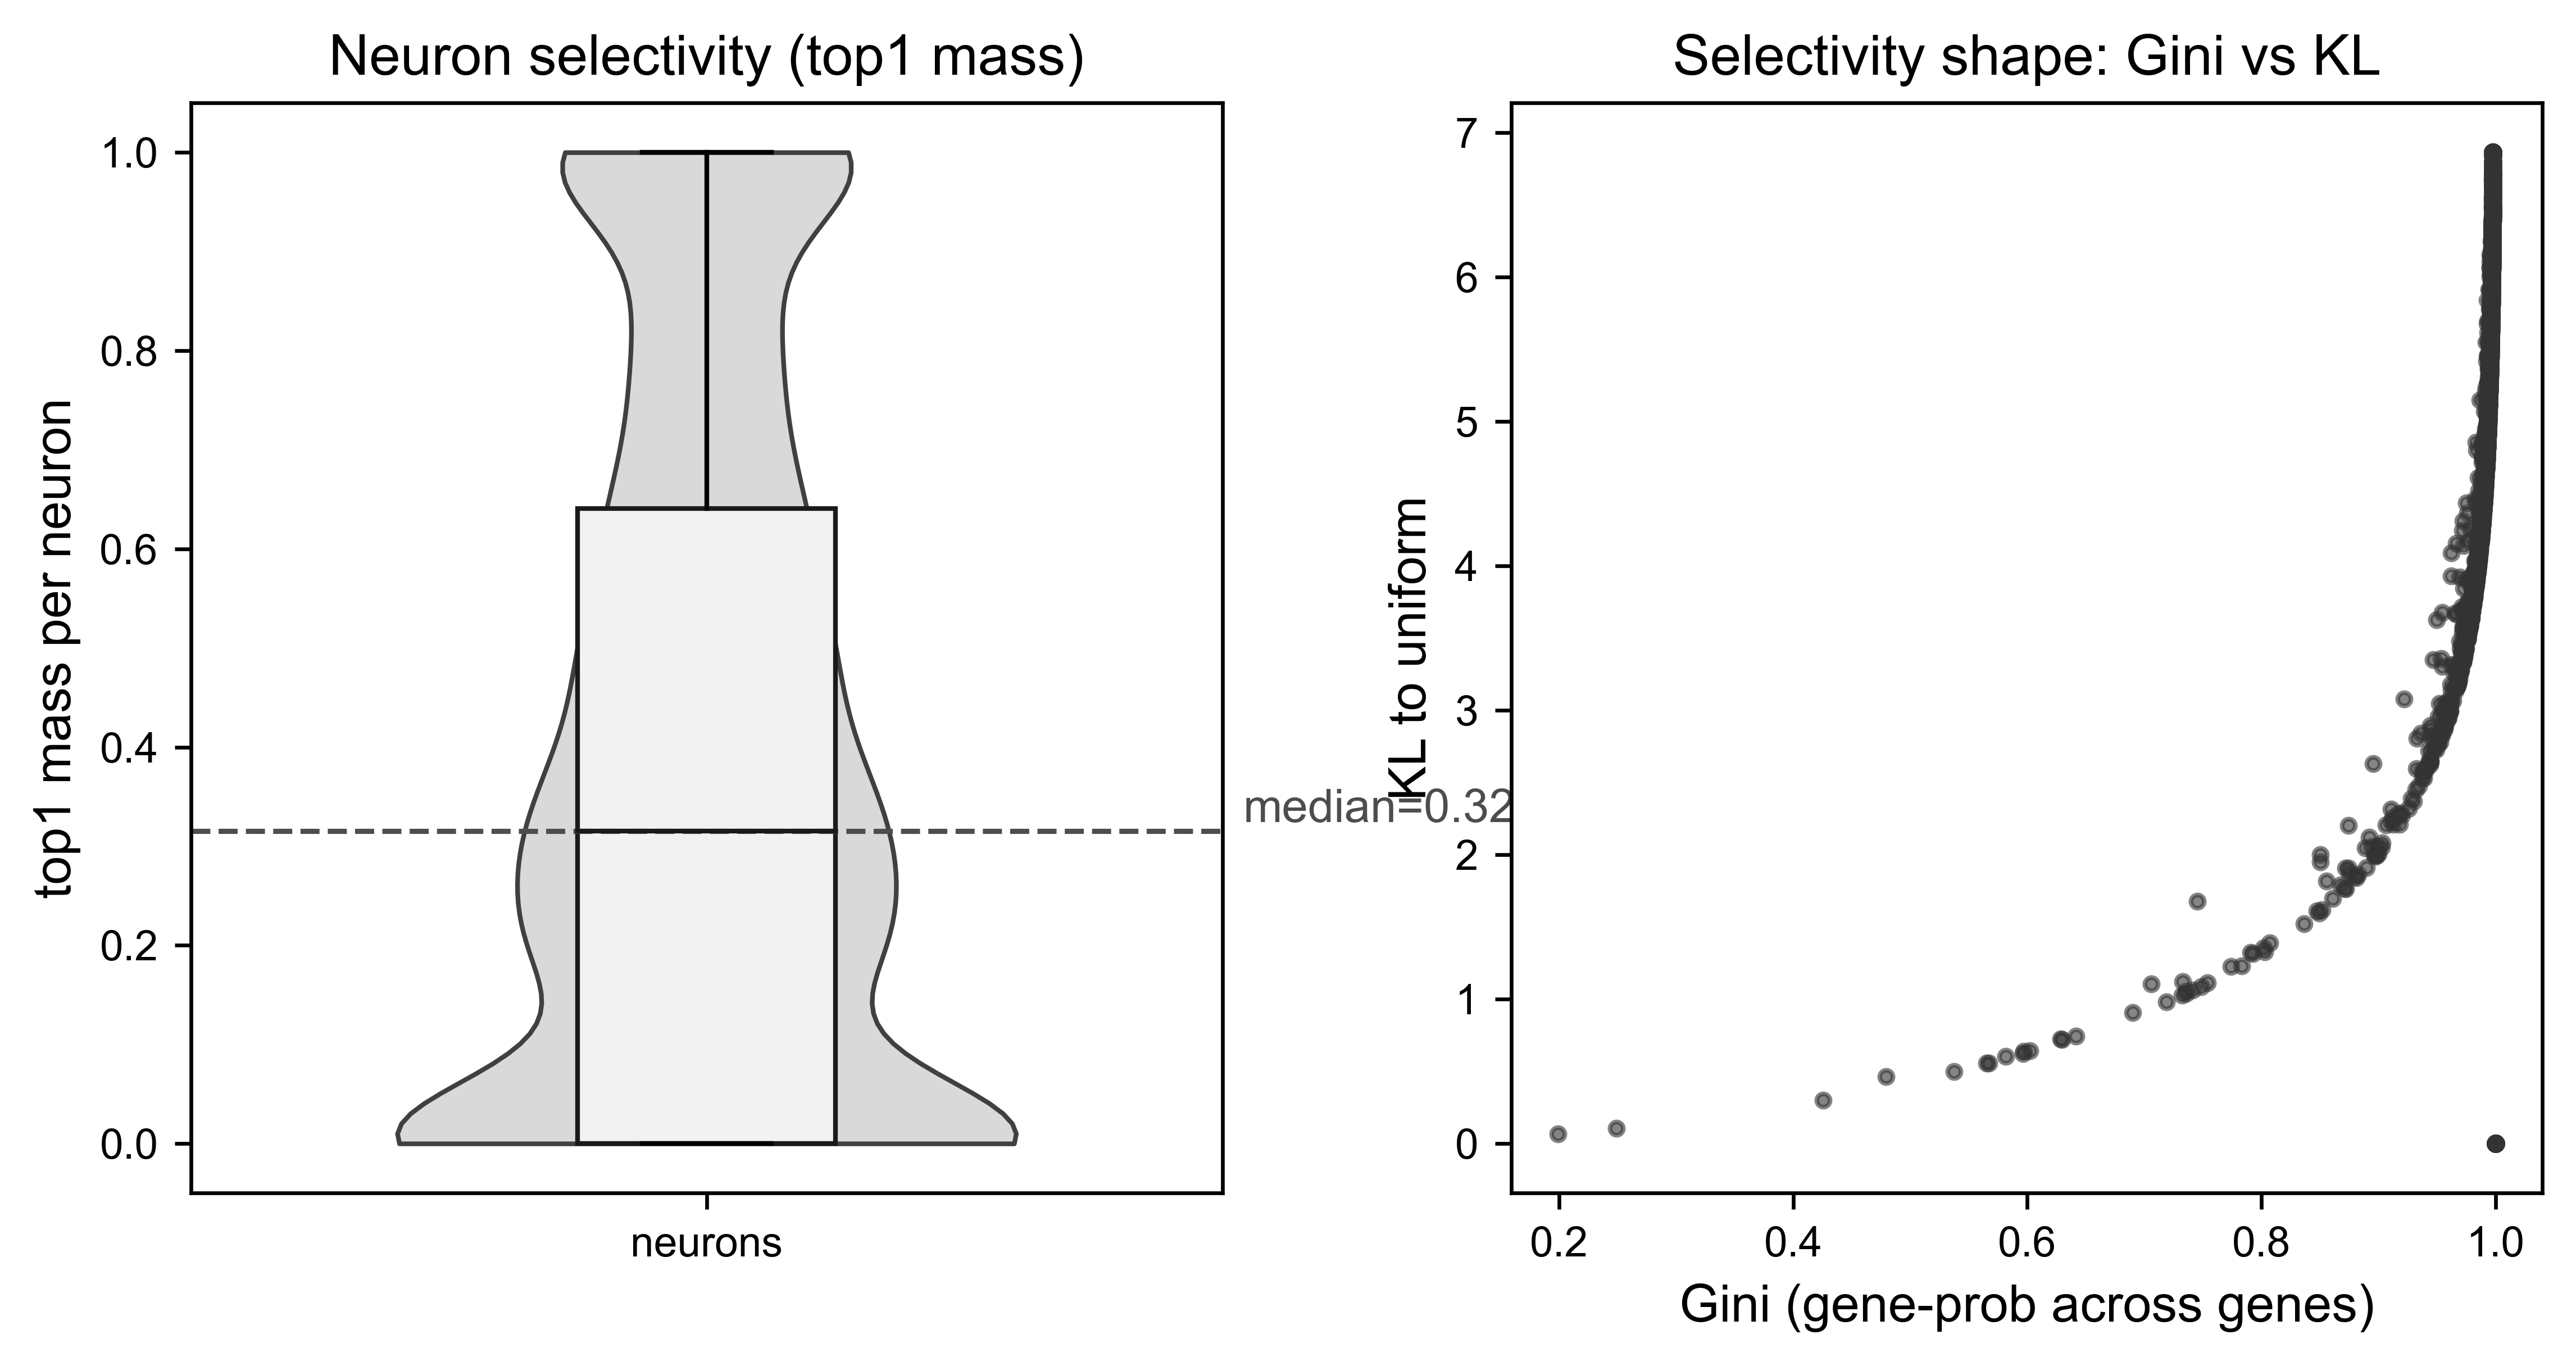

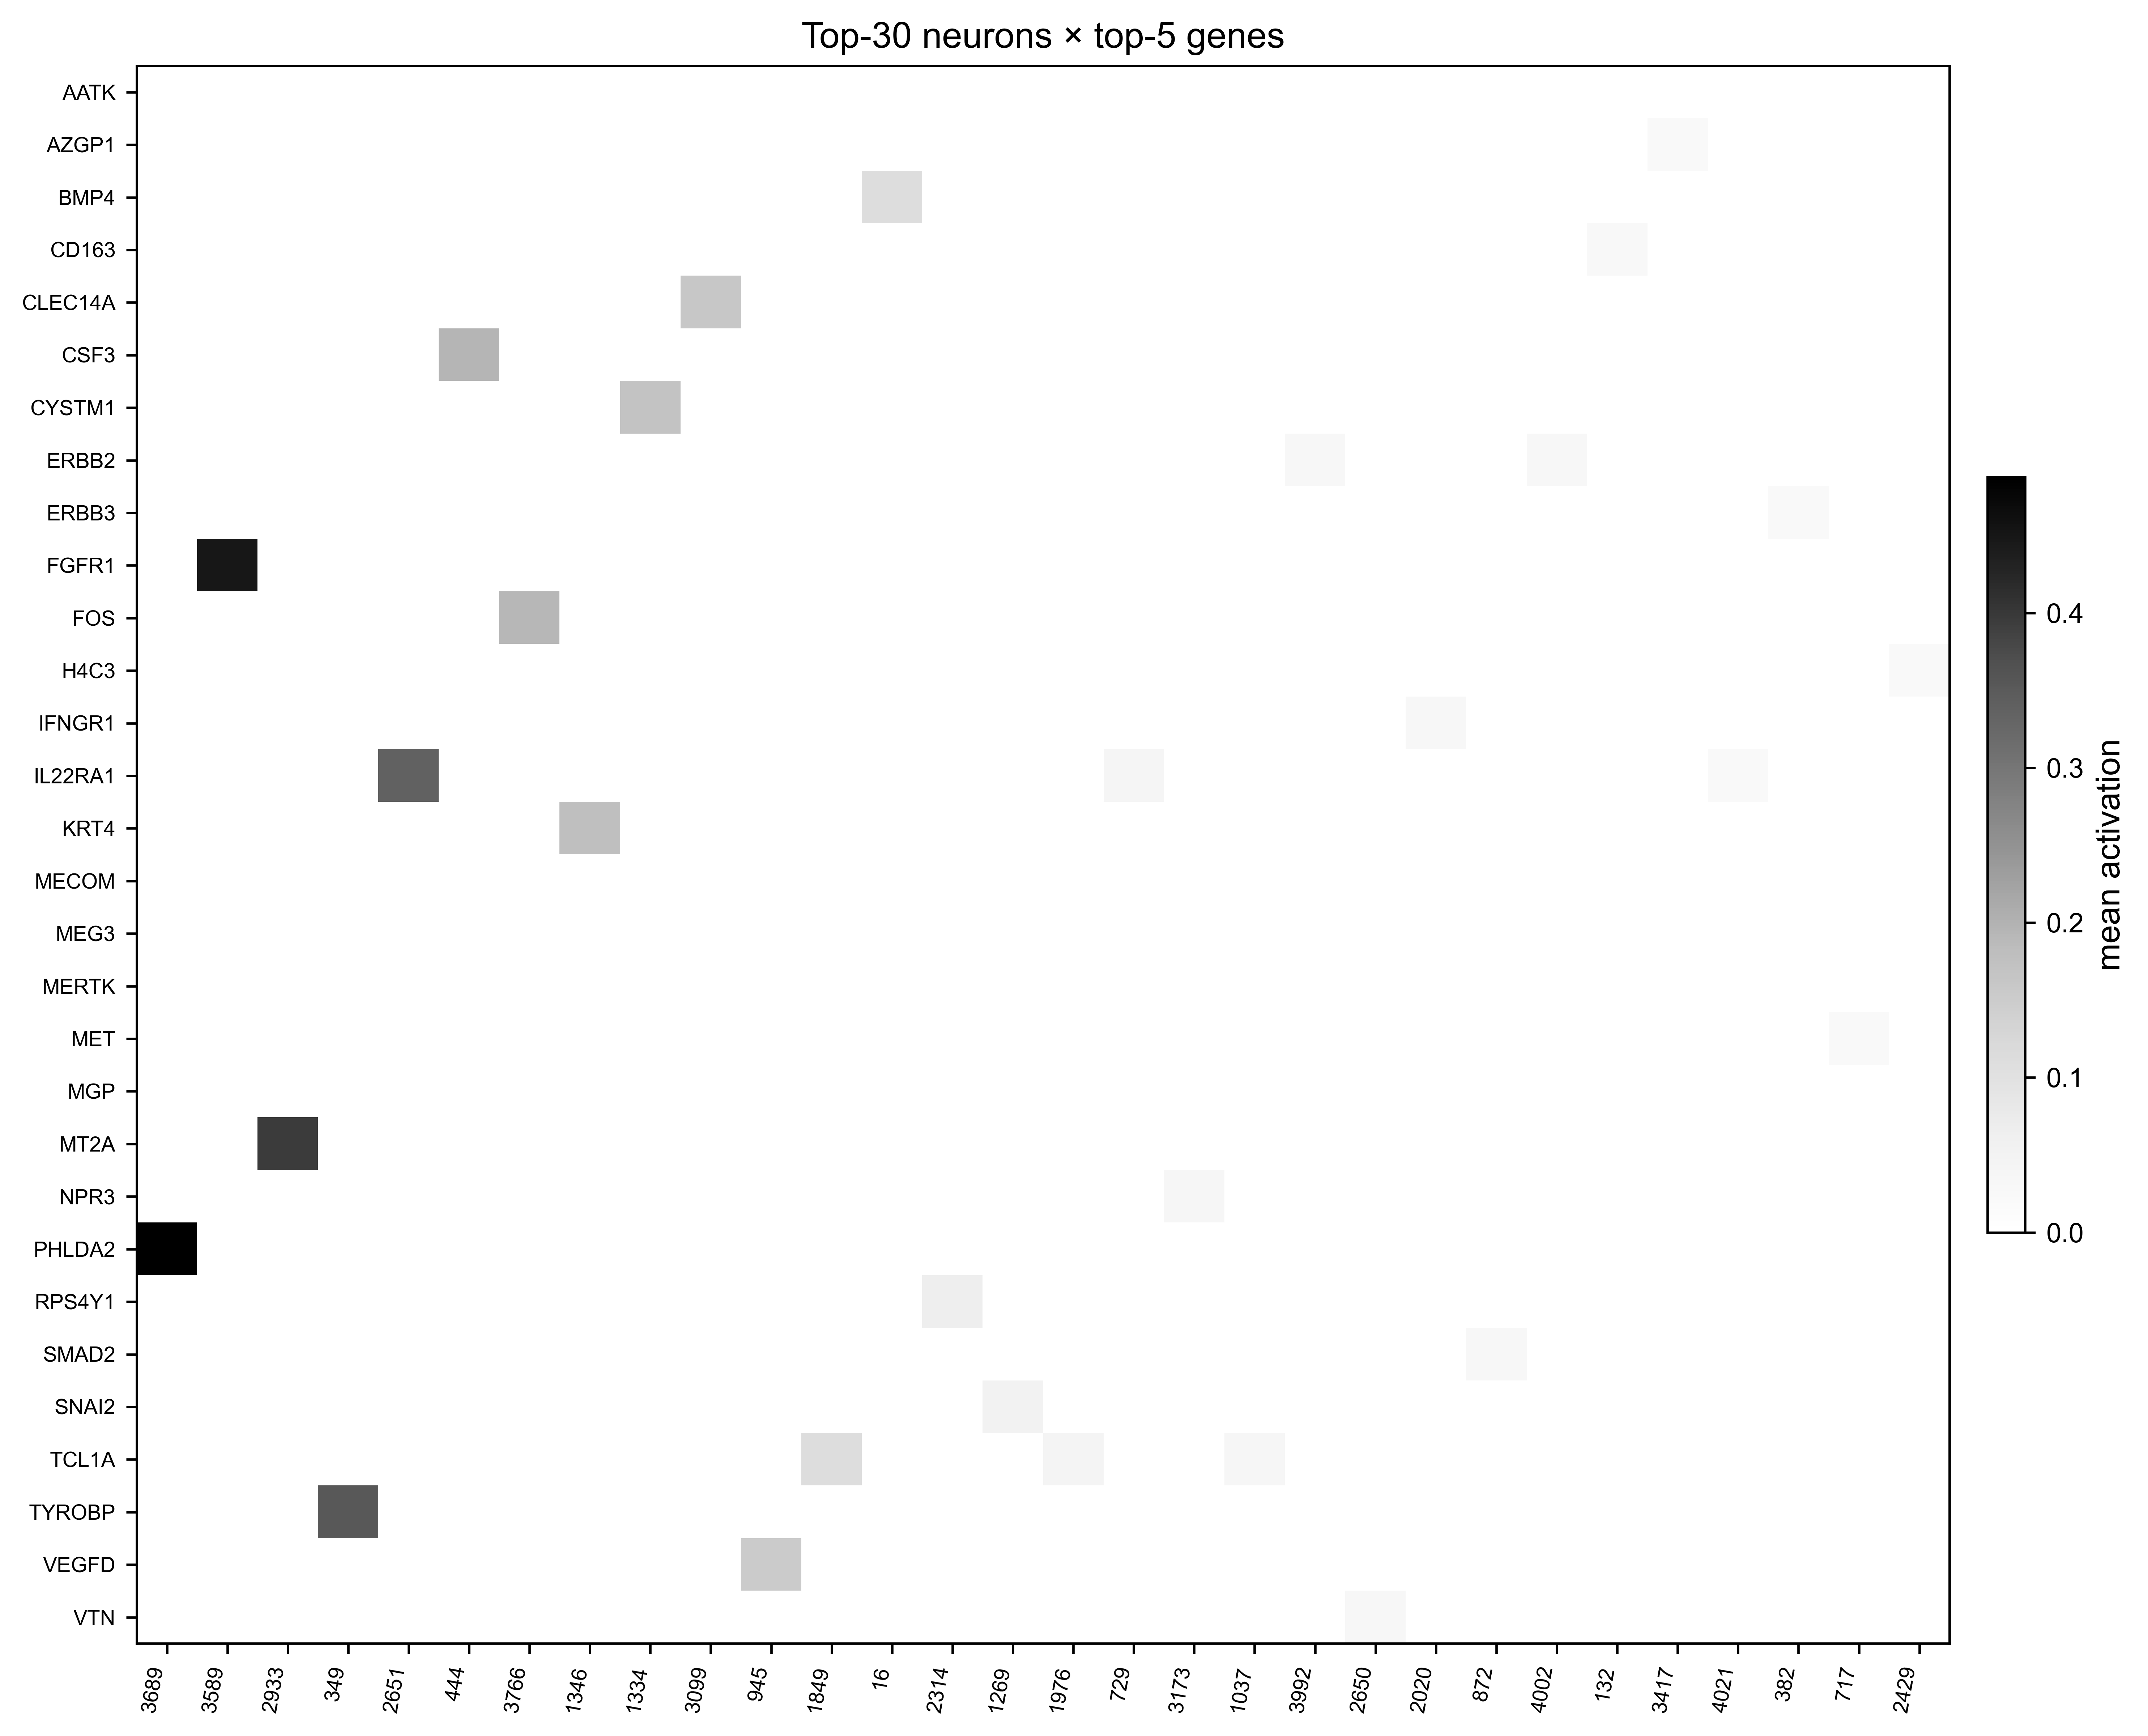

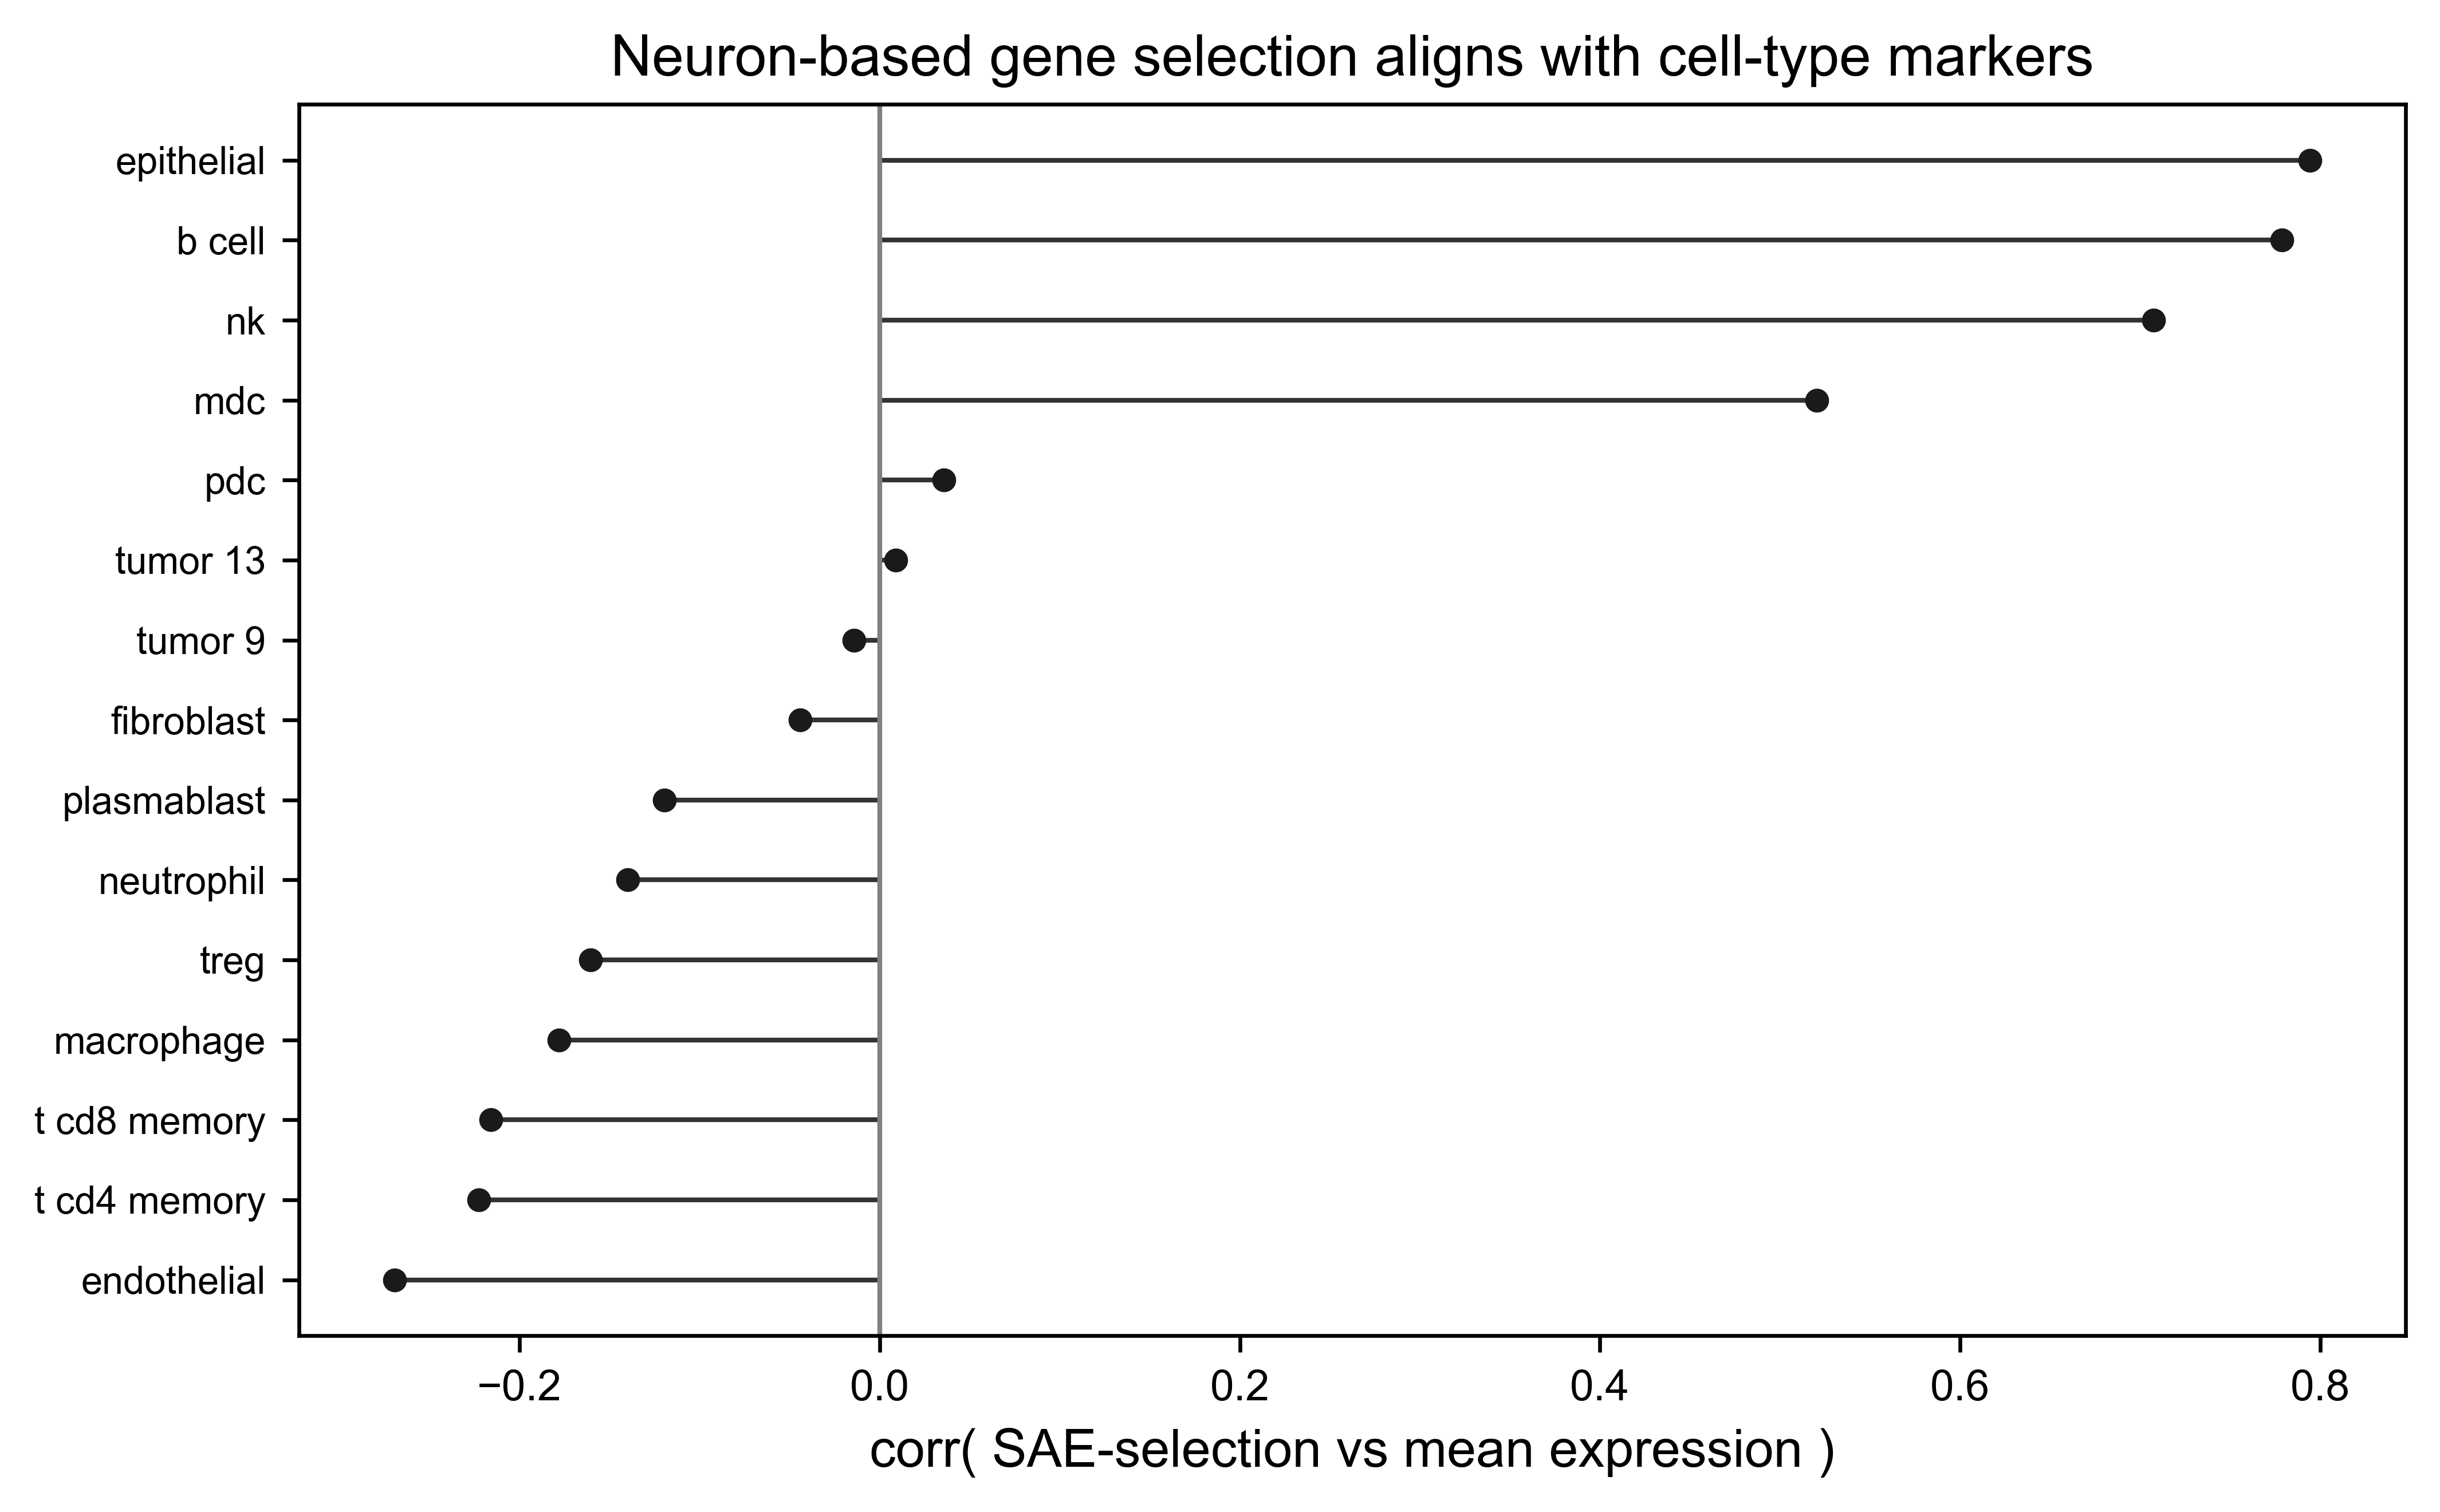

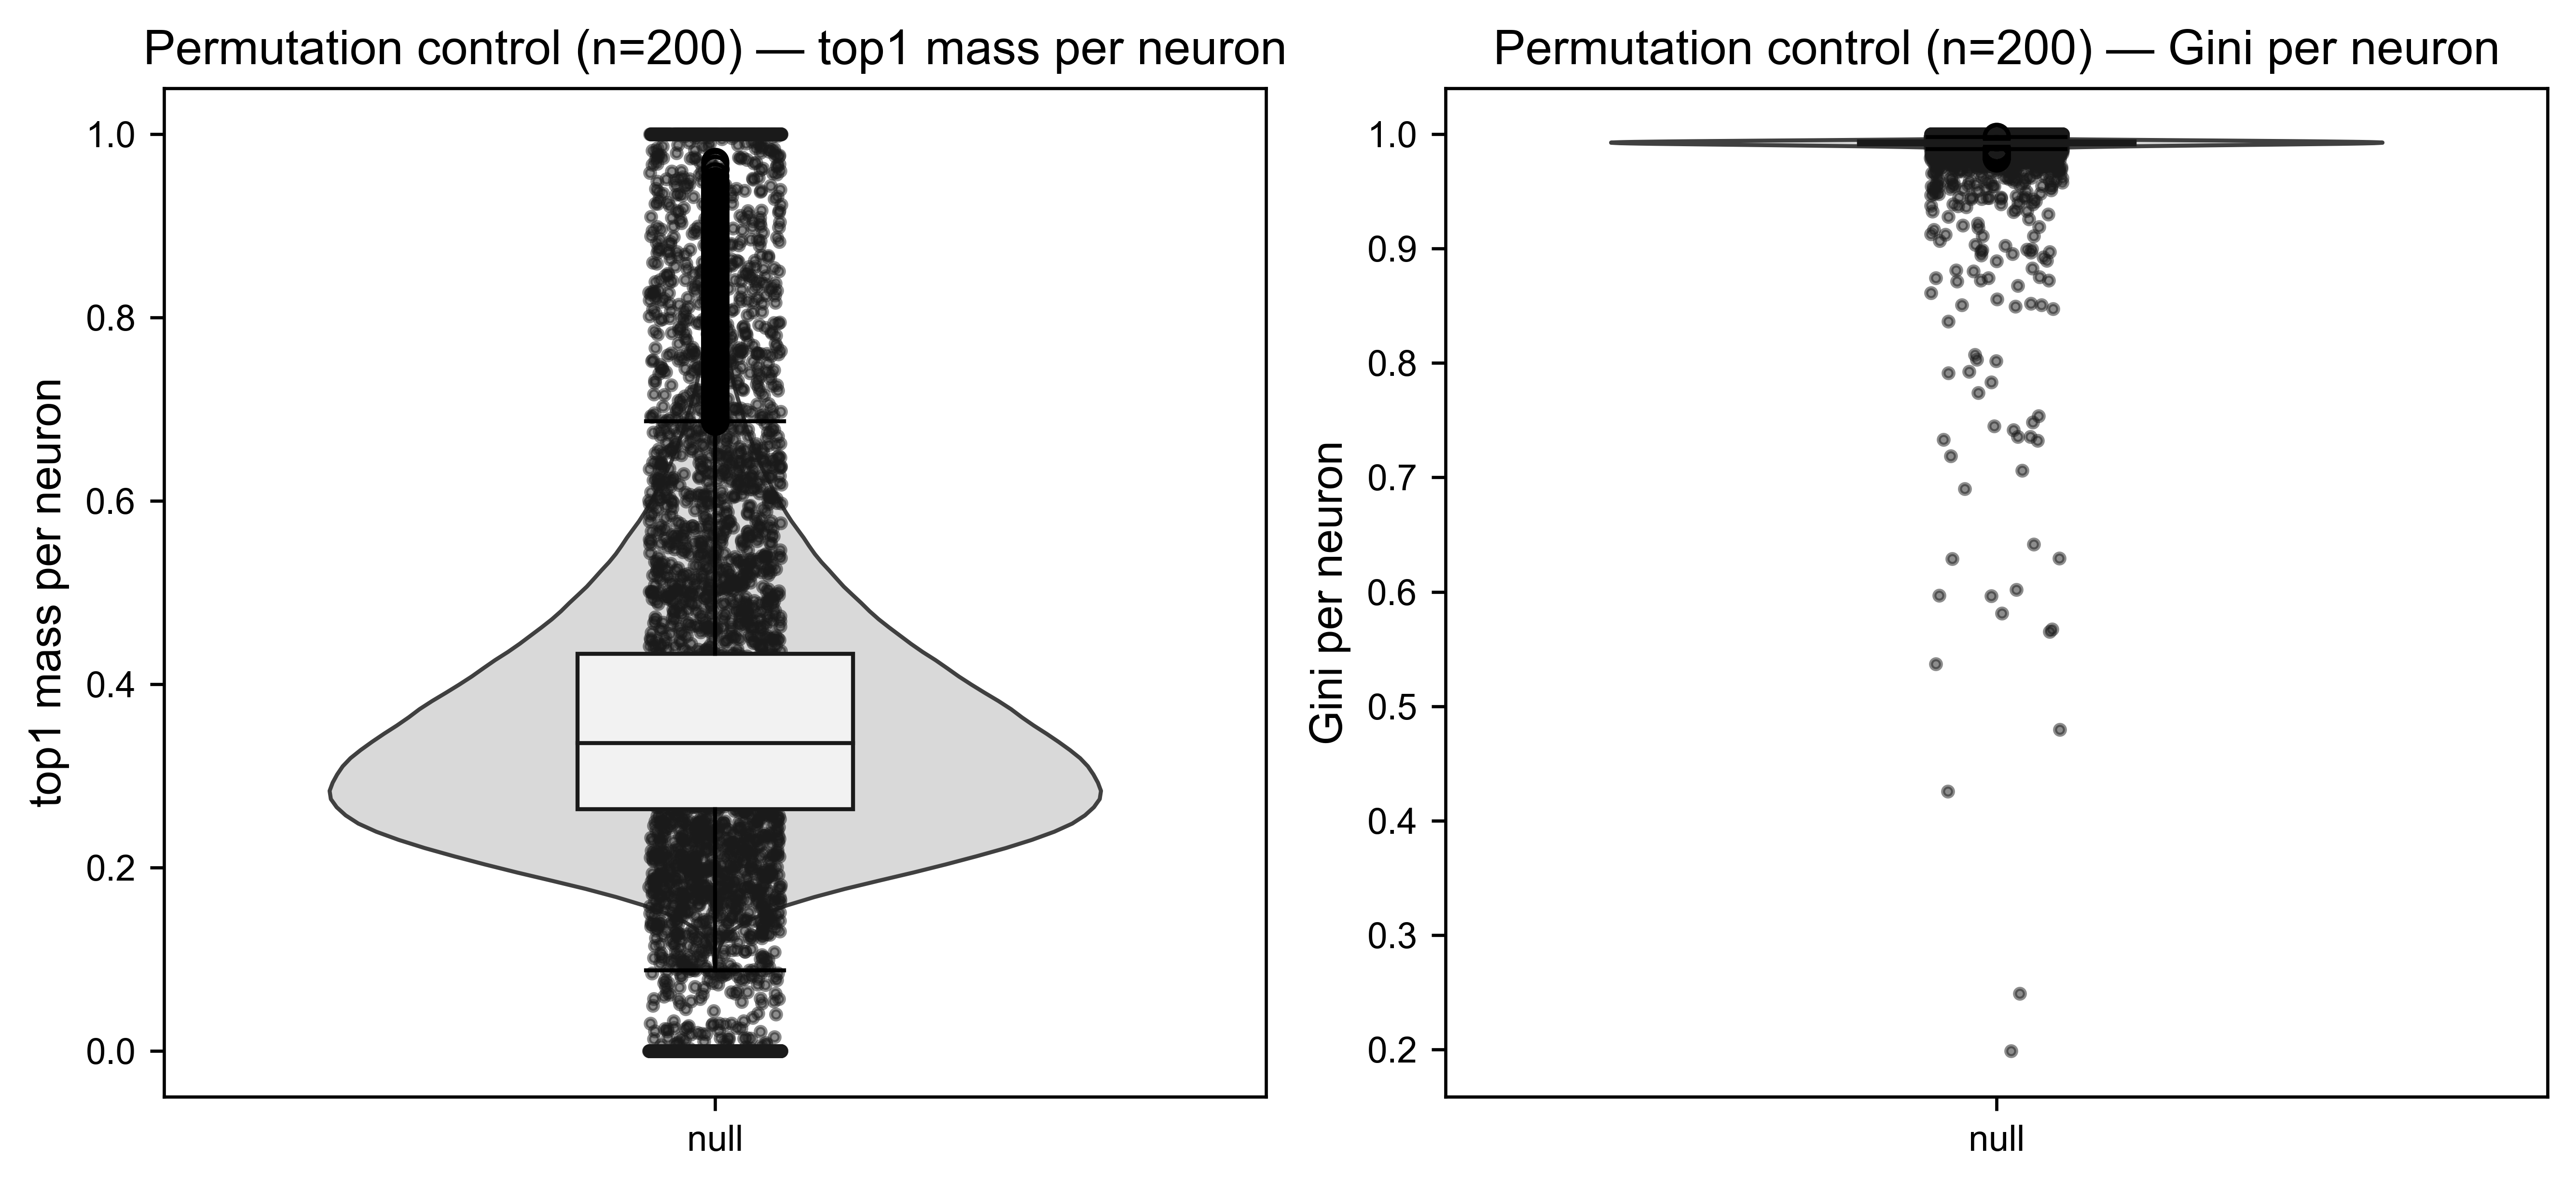

/tmp/ipykernel_189965/4241162633.py:264: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


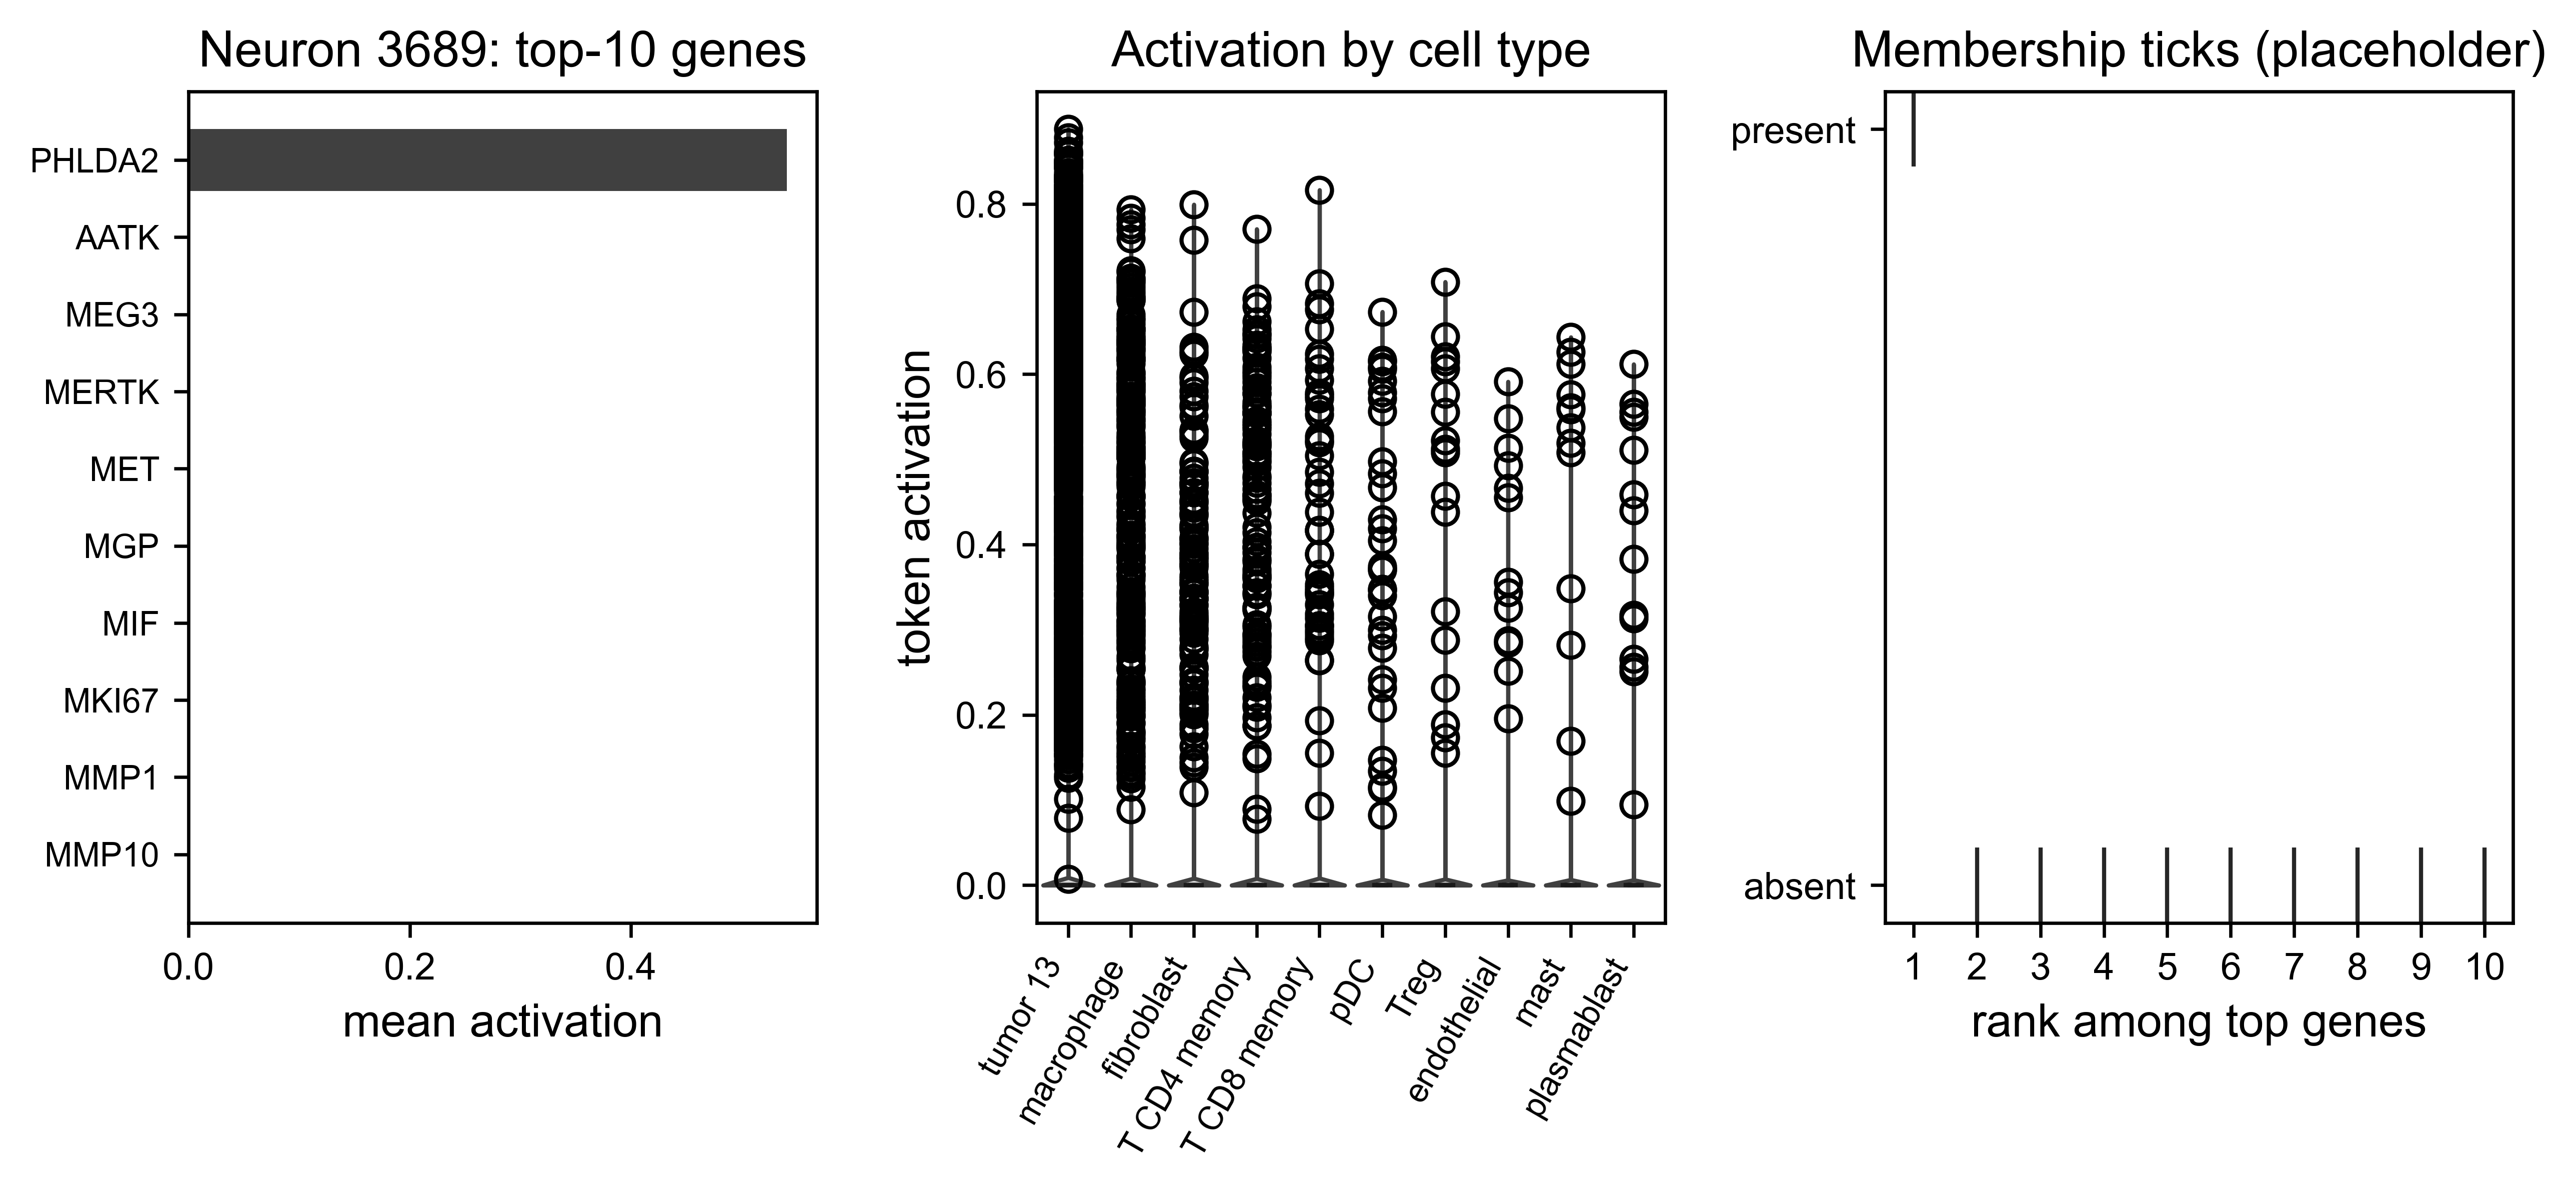

In [ ]:
# ===========================
# Figure pack: SAE gene-token selectivity
# Style: consistent with CCC (B/W-leaning), high-DPI, minimal clutter
# Inputs assumed present in session:
#   - out: summary dataframe from gene_token_specificity()
#   - mean_mat: (G x P) DataFrame (genes x neurons) of mean activations
#   - H_SAE: (M x P) token-level latents
#   - gene_ids_token: (M,) tokens' gene IDs
#   - CELLTYPE_TOKEN: (M,) tokens' cell types
# Optional:
#   - corr_by_ct: pd.Series or dict {cell_type -> correlation float}
#   - enrich_df: pd.DataFrame with columns ['term','-log10FDR','k'] for enrichment plot
# Save dir:
SAVE_DIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/figures"
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs(SAVE_DIR, exist_ok=True)

FIG_DPI = 600
FONT_FAMILY = "Arial"
plt.rcParams.update({
    "figure.dpi": FIG_DPI, "savefig.dpi": FIG_DPI,
    "font.family": FONT_FAMILY,
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "pdf.fonttype": 42,   # TrueType -> editable text in Illustrator
    "ps.fonttype": 42,
})

# ---------------------------
# 1) Neuron selectivity landscape
# ---------------------------
def fig1_selectivity_landscape(out: pd.DataFrame, save_path=None):
    # Violin/box of top1_mass + scatter Gini vs KL
    top1 = out["top1_mass"].to_numpy()
    gini = out["gene_gini"].to_numpy()
    kl   = out["gene_kl"].to_numpy()

    fig = plt.figure(figsize=(9, 4.2))
    gs = fig.add_gridspec(1, 2, wspace=0.28)

    # A. violin/box
    ax1 = fig.add_subplot(gs[0,0])
    parts = ax1.violinplot([top1], showmeans=False, showextrema=False, widths=0.6)
    for pc in parts['bodies']:
        pc.set_facecolor("0.85"); pc.set_edgecolor("0.25"); pc.set_alpha(1.0)
    ax1.boxplot([top1], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor="0.95", edgecolor="0.1"),
                medianprops=dict(color="0.1"))
    med = float(np.median(top1))
    ax1.axhline(med, ls="--", lw=1.1, color="0.3")
    ax1.set_xticks([1]); ax1.set_xticklabels(["neurons"])
    ax1.set_ylabel("top1 mass per neuron")
    ax1.set_title("Neuron selectivity (top1 mass)")
    ax1.text(1.02, med, f"median={med:.2f}", va="bottom", ha="left", color="0.3", transform=ax1.get_yaxis_transform())

    # B. scatter gini vs kl
    ax2 = fig.add_subplot(gs[0,1])
    ax2.scatter(gini, kl, s=8, c="0.2", alpha=0.6, rasterized=True)
    ax2.set_xlabel("Gini (gene-prob across genes)")
    ax2.set_ylabel("KL to uniform")
    ax2.set_title("Selectivity shape: Gini vs KL")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# ---------------------------
# 2) Top-genes heatmap per neuron
# ---------------------------
def fig2_topgenes_heatmap(mean_mat: pd.DataFrame, out: pd.DataFrame, top_neurons=30, top_k_genes=5, save_path=None):
    # Pick top neurons by top1_mass
    sel = out.sort_values("top1_mass", ascending=False).head(top_neurons)
    neurons = sel["neuron"].to_numpy()
    # Build a masked matrix (genes x neurons) keeping only top_k genes per neuron
    sub = mean_mat.loc[:, neurons]  # (G x top_n)
    mask = np.zeros_like(sub.values, dtype=bool)
    for j in range(sub.shape[1]):
        order = np.argsort(-sub.values[:, j])[:top_k_genes]
        mask[order, j] = True
    A = sub.values.copy()
    A[~mask] = 0.0

    # Clip for better contrast
    finite = A[A>0]
    vmax = np.quantile(finite, 0.98) if finite.size else 1.0
    vmax = max(vmax, 1e-6)

    # Keep only genes that appear at least once
    keep_rows = mask.any(axis=1)
    genes_kept = sub.index[keep_rows]
    A = A[keep_rows, :]

    fig, ax = plt.subplots(figsize=(min(10, 0.28*top_neurons+2), 0.22*len(genes_kept)+1.5))
    im = ax.imshow(A, cmap="Greys", vmin=0, vmax=vmax, interpolation="nearest", aspect="auto")
    ax.set_xticks(range(len(neurons))); ax.set_xticklabels(neurons, rotation=80, ha="right", fontsize=7)
    ax.set_yticks(range(len(genes_kept))); ax.set_yticklabels(genes_kept, fontsize=7)
    ax.set_title(f"Top-{top_neurons} neurons × top-{top_k_genes} genes")
    cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
    cbar.set_label("mean activation")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# ---------------------------
# 3) Per–cell type alignment plot
# ---------------------------
def fig3_celltype_alignment(corr_by_ct, save_path=None):
    # corr_by_ct: dict or Series {cell_type -> correlation}
    s = pd.Series(corr_by_ct).dropna().sort_values()
    fig, ax = plt.subplots(figsize=(7.2, 4.5))
    y = np.arange(len(s))
    ax.hlines(y, 0, s.values, color="0.2", lw=1)
    ax.plot(s.values, y, "o", ms=4, color="0.1")
    ax.axvline(0, color="0.5", lw=1)
    ax.set_yticks(y); ax.set_yticklabels(s.index, fontsize=8)
    ax.set_xlabel("corr( SAE-selection vs mean expression )")
    ax.set_title("Neuron-based gene selection aligns with cell-type markers")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# ---------------------------
# 4) Null / robustness control (permutation)
# ---------------------------
def fig4_permutation_null(mean_mat: pd.DataFrame, n_perm=200, random_state=7, save_path=None):
    # Break neuron–gene structure by independently permuting neuron columns per gene (row-wise shuffles).
    rng = np.random.default_rng(random_state)
    A = np.clip(mean_mat.values, 0, None)  # (G x P)
    G, P = A.shape

    def _probs(M):
        s = M.sum(axis=0, keepdims=True)
        s[s<=0] = 1.0
        return M / s

    # observed per-neuron stats (top1_mass, gini)
    Pobs = _probs(A)
    top1_obs = A.max(axis=0) / (A.sum(axis=0) + 1e-12)

    # Gini per neuron using probs across genes (column-wise)
    order = np.argsort(Pobs, axis=0)
    Psorted = np.take_along_axis(Pobs, order, axis=0)
    weights = (np.arange(G, 0, -1) / G).reshape(G,1)
    gini_obs = 1.0 - 2.0 * np.sum(weights * Psorted, axis=0)

    # null replicates: shuffle columns within each row
    top1_null = []
    gini_null = []
    for _ in range(n_perm):
        Aperm = A.copy()
        for g in range(G):
            Aperm[g,:] = Aperm[g, rng.permutation(P)]
        Pperm = _probs(Aperm)
        top1_null.append(Aperm.max(axis=0) / (Aperm.sum(axis=0) + 1e-12))
        order = np.argsort(Pperm, axis=0)
        Psorted = np.take_along_axis(Pperm, order, axis=0)
        gini_null.append(1.0 - 2.0 * np.sum(weights * Psorted, axis=0))
    top1_null = np.array(top1_null)  # (n_perm x P)
    gini_null = np.array(gini_null)

    # Plot violins of null + observed dot overlay
    fig, axes = plt.subplots(1, 2, figsize=(9, 4.2))
    for ax, vals, obs, title in [
        (axes[0], top1_null.flatten(), top1_obs, "top1 mass per neuron"),
        (axes[1], gini_null.flatten(), gini_obs, "Gini per neuron")
    ]:
        parts = ax.violinplot([vals], showmeans=False, showextrema=False, widths=0.7)
        for pc in parts['bodies']:
            pc.set_facecolor("0.85"); pc.set_edgecolor("0.25"); pc.set_alpha(1.0)
        ax.boxplot([vals], widths=0.25, patch_artist=True,
                   boxprops=dict(facecolor="0.95", edgecolor="0.1"),
                   medianprops=dict(color="0.1"))
        # overlay observed (all neurons) as small jittered points
        xobs = 1 + (np.random.rand(len(obs)) - 0.5) * 0.12
        ax.scatter(xobs, obs, s=6, c="0.1", alpha=0.5, rasterized=True)
        ax.set_xticks([1]); ax.set_xticklabels(["null"])
        ax.set_ylabel(title)
        ax.set_title(f"Permutation control (n={n_perm}) — {title}")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# ---------------------------
# 5) Functional enrichment sanity (dot plot)
# ---------------------------
def fig5_enrichment_dotplot(enrich_df: pd.DataFrame, top_n=15, save_path=None):
    # enrich_df columns: 'term', '-log10FDR', 'k' (hit count) — precomputed upstream
    df = enrich_df.copy().sort_values("-log10FDR", ascending=False).head(top_n)
    df = df.iloc[::-1]  # plot strongest at top
    fig, ax = plt.subplots(figsize=(7.5, 0.42*len(df)+1.2))
    sc = ax.scatter(df["-log10FDR"], np.arange(len(df)), s=20 + 8*df["k"],
                    c="0.2", alpha=0.8)
    ax.set_yticks(np.arange(len(df))); ax.set_yticklabels(df["term"], fontsize=8)
    ax.set_xlabel(r"$-\log_{10}(\mathrm{FDR})$")
    ax.set_title("GO/Pathway enrichment of neuron-selected genes")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# ---------------------------
# 6) Case-study neurons (3-panel)
# ---------------------------
def fig6_case_neuron(neuron_id: int,
                     H_SAE: np.ndarray,
                     CELLTYPE_TOKEN: np.ndarray,
                     gene_ids_token: np.ndarray,
                     mean_mat: pd.DataFrame,
                     top_k_genes=10,
                     save_path=None):
    # Top genes bar
    if neuron_id not in mean_mat.columns:
        raise ValueError(f"neuron {neuron_id} not in mean_mat.columns")
    col = mean_mat[neuron_id]
    order = np.argsort(-col.values)[:top_k_genes]
    gnames = col.index[order]
    gvals  = col.values[order]

    # Violin of neuron activation per cell type (token-level aggregation)
    z = H_SAE[:, neuron_id].astype(float)
    df = pd.DataFrame({"ct": CELLTYPE_TOKEN.astype(str), "z": z})
    # Keep top 10 cell types by token count
    ct_order = df["ct"].value_counts().head(10).index.tolist()
    df = df[df["ct"].isin(ct_order)]
    df["ct"] = pd.Categorical(df["ct"], categories=ct_order, ordered=True)

    fig = plt.figure(figsize=(10, 3.6))
    gs = fig.add_gridspec(1, 3, wspace=0.35)

    # (i) top genes
    ax1 = fig.add_subplot(gs[0,0])
    ax1.barh(range(len(gnames)), gvals, color="0.25")
    ax1.set_yticks(range(len(gnames))); ax1.set_yticklabels(gnames, fontsize=8)
    ax1.invert_yaxis()
    ax1.set_xlabel("mean activation"); ax1.set_title(f"Neuron {neuron_id}: top-{top_k_genes} genes")

    # (ii) per-cell type violin (hand-rolled)
    ax2 = fig.add_subplot(gs[0,1])
    xs = []
    for idx, ct in enumerate(ct_order):
        vals = df.loc[df["ct"]==ct, "z"].values
        if len(vals)==0: continue
        parts = ax2.violinplot([vals], positions=[idx], showmeans=False, showextrema=False, widths=0.8)
        for pc in parts['bodies']:
            pc.set_facecolor("0.85"); pc.set_edgecolor("0.25"); pc.set_alpha(1.0)
        ax2.boxplot([vals], positions=[idx], widths=0.25, patch_artist=True,
                    boxprops=dict(facecolor="0.95", edgecolor="0.1"),
                    medianprops=dict(color="0.1"))
        xs.append(idx)
    ax2.set_xticks(range(len(ct_order))); ax2.set_xticklabels(ct_order, rotation=60, ha="right", fontsize=8)
    ax2.set_ylabel("token activation"); ax2.set_title("Activation by cell type")

    # (iii) gene-set ticks (if you have TARGETS_DICT, you can overlay membership)
    # Placeholder: show presence counts among top genes (for demonstration)
    ax3 = fig.add_subplot(gs[0,2])
    ax3.plot(np.arange(top_k_genes), (gvals>0).astype(int), "|", ms=18, color="0.15")
    ax3.set_yticks([0,1]); ax3.set_yticklabels(["absent","present"])
    ax3.set_xticks(range(top_k_genes)); ax3.set_xticklabels(range(1, top_k_genes+1))
    ax3.set_xlabel("rank among top genes")
    ax3.set_title("Membership ticks (placeholder)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# ===========================
# ---- Run the figure pack ----
# (Customize paths or parameters as you wish)
out = gene_df
mean_mat = g_means
sample_idx = shared_idx
diag = gene_diag

fig1_selectivity_landscape(out, save_path=f"{SAVE_DIR}/fig1_selectivity_landscape.pdf")
fig2_topgenes_heatmap(mean_mat, out, top_neurons=30, top_k_genes=5, save_path=f"{SAVE_DIR}/fig2_topgenes_heatmap.pdf")

# Example for fig3 (use your measured correlations)
corr_by_ct = {
    "b cell": 0.778864687590508,
    "epithelial": 0.7942674701265332,
    "nk": 0.7075874131299837,
    "mdc": 0.5205752724099304,
    "pdc": 0.03561779402533246,
    "fibroblast": -0.04414817266853327,
    "plasmablast": -0.11952048019530223,
    "neutrophil": -0.1398365515123749,
    "treg": -0.16061835781273417,
    "macrophage": -0.17818386976960315,
    "t cd4 memory": -0.2227157472892557,
    "t cd8 memory": -0.21593485742227736,
    "endothelial": -0.2692436387915198,
    "tumor 13": 0.008775797044017068,
    "tumor 9": -0.01433632667905665,
}
fig3_celltype_alignment(corr_by_ct, save_path=f"{SAVE_DIR}/fig3_celltype_alignment.pdf")

fig4_permutation_null(mean_mat, n_perm=200, random_state=7, save_path=f"{SAVE_DIR}/fig4_perm_null.pdf")

# fig5 requires a precomputed enrichment table; stub example:
# enrich_df = pd.DataFrame({"term":[...], "-log10FDR":[...], "k":[...]})
# fig5_enrichment_dotplot(enrich_df, top_n=15, save_path=f"{SAVE_DIR}/fig5_enrichment.png")

# Pick a neuron ID you like from `out['neuron']`
# nid = int(out.iloc[0]["neuron"])
# fig6_case_neuron(nid, H_SAE, CELLTYPE_TOKEN, gene_ids_token, mean_mat,
#                  top_k_genes=10, save_path=f"{SAVE_DIR}/fig6_case_neuron_{nid}.pdf")

# SLR: correlation between gene markers and feature markers

/home/huy21/anaconda3/envs/scgpt/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/huy21/anaconda3/envs/scgpt/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/huy21/anaconda3/envs/scgpt/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/huy21/anaconda3/envs/scgpt/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/huy21/anaconda3/envs/scgpt/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/huy21/anaconda

[logit_df] ok: 602 / 800
       cell_type  corr_selection_vs_meanExpr
21          Treg                   -0.203518
14            NK                   -0.076372
16   T CD8 naive                   -0.044356
9     neutrophil                   -0.035516
8       monocyte                   -0.026540
6     epithelial                   -0.024786
17        B-cell                   -0.019358
3        tumor 6                   -0.000911
15       tumor 5                    0.003173
20  T CD4 memory                    0.014344
11      tumor 12                    0.018856
12   T CD4 naive                    0.047847
19           mDC                    0.068355
5        tumor 9                    0.172105
7    endothelial                    0.187517
18           pDC                    0.235423
2     macrophage                    0.248709
0       tumor 13                    0.345818
13  T CD8 memory                    0.380841
4     fibroblast                    0.489568
10          mast              

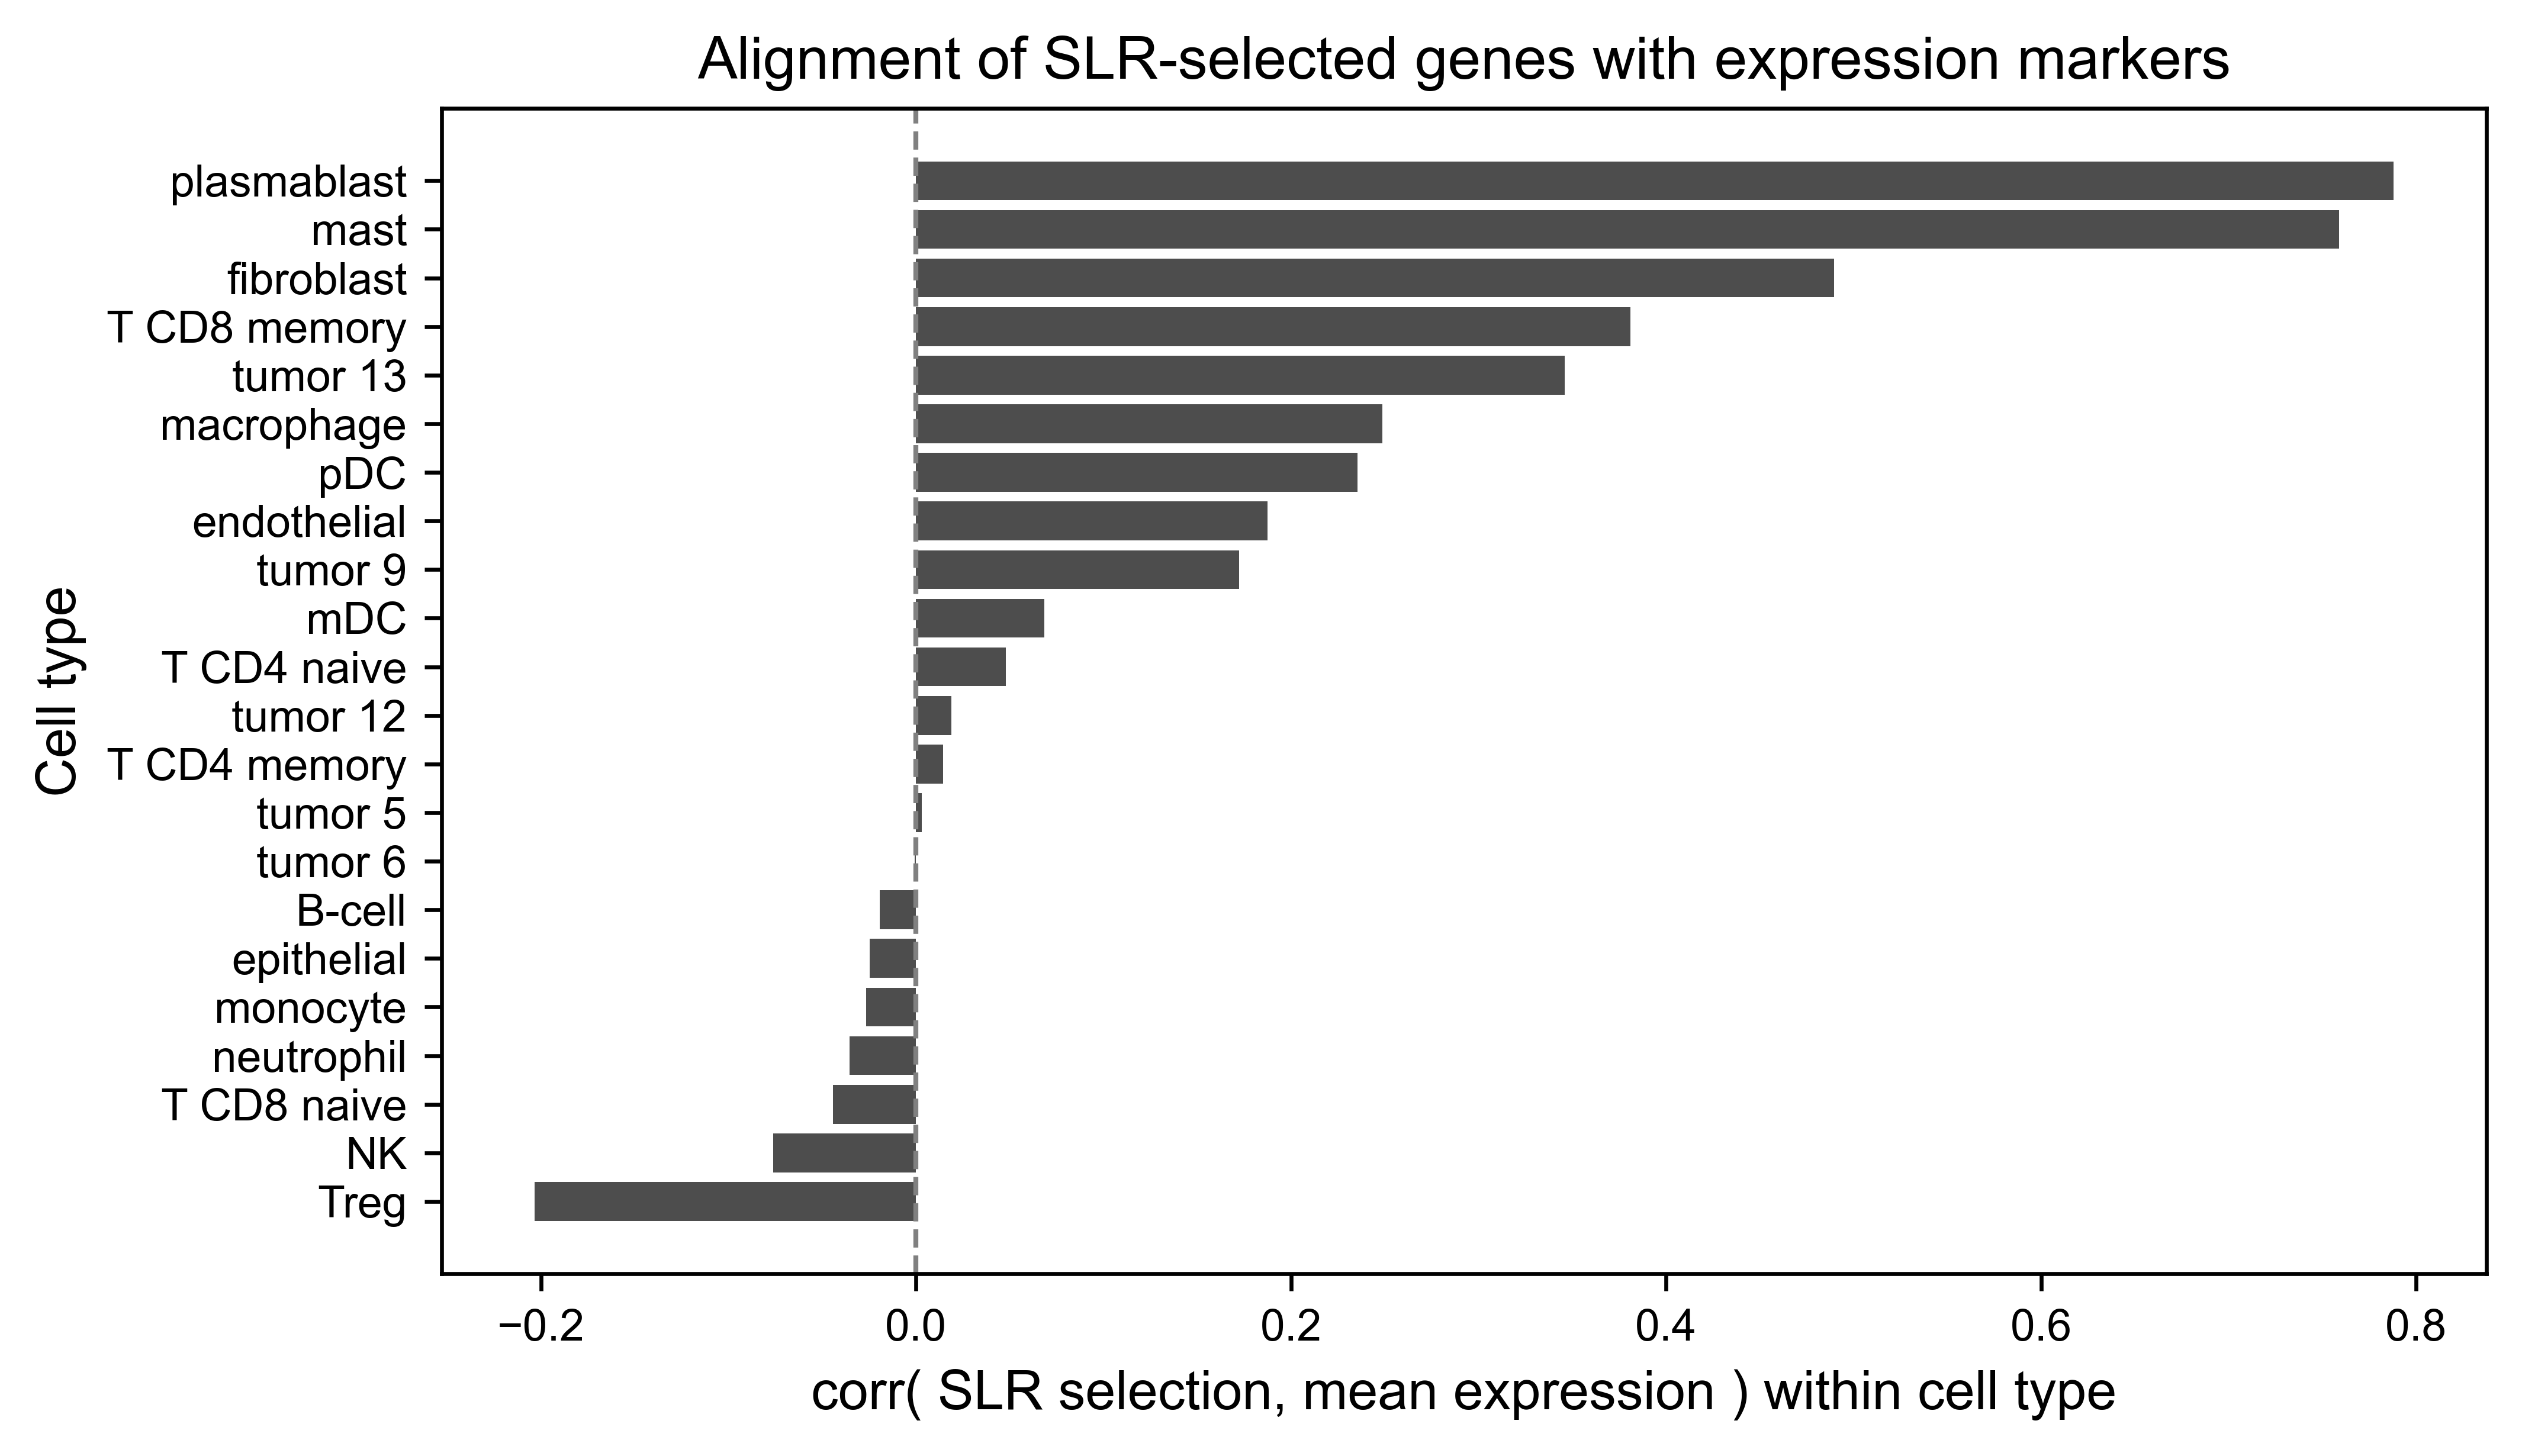

Saved: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/final_figures_for_fts_markers/selection_expr_correlations_by_type.pdf


In [10]:
# ==== CONFIG you can tweak ====
OUTDIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/final_figures_for_fts_markers"
CT_COL = "author_cell_type"  # or None to auto-pick
NEURONS = 800                # set None/0 to use ALL neurons (slower)
SCREEN_TOP_N = 2000
TOPK_GENES_OUT = 10
TOPN_PER_NEURON = None       # keep all selected genes per neuron
AGG = "max"                  # 'max' preserves spiky neuron responses

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

os.makedirs(OUTDIR, exist_ok=True)

def _to_csr(X): 
    return X if sparse.issparse(X) else sparse.csr_matrix(X)

def _prefer_symbols(adata, idx=None):
    base = (adata.var["index"].astype(str).to_numpy()
            if "index" in adata.var.columns else adata.var_names.astype(str).to_numpy())
    return base if idx is None else base[idx]

# --- token→cell aggregation ---
def aggregate_neuron_activation_per_cell(H_SAE, cell_idx_token, neuron_ids=None, agg="max", chunk=600_000):
    M, P = H_SAE.shape
    sel = np.arange(P, dtype=int) if neuron_ids is None else np.asarray(neuron_ids, dtype=int)
    H_sub = H_SAE[:, sel]
    cells_used, inv = np.unique(np.asarray(cell_idx_token, np.int64), return_inverse=True)
    C, K = cells_used.size, H_sub.shape[1]
    if agg == "mean":
        sums = np.zeros((C, K), np.float32); np.add.at(sums, inv, H_sub)
        counts = np.bincount(inv, minlength=C).astype(np.float32).reshape(C, 1)
        H_cell = sums / np.maximum(counts, 1.0)
    else:
        H_cell = np.full((C, K), -np.inf, np.float32)
        arangeK = np.arange(K)[None, :]
        for start in range(0, M, chunk):
            sl = slice(start, min(M, start+chunk))
            np.maximum.at(H_cell, (inv[sl, None], arangeK), H_sub[sl, :])
        H_cell[~np.isfinite(H_cell)] = 0.0
    return cells_used, sel, H_cell

def binarize_cell_targets(H_cell, min_pos=10, min_neg=10, use_percentile=0.90, fallback_thresh=0.05):
    C, K = H_cell.shape
    targets, kept, used_thresh = [], np.zeros(K, bool), np.zeros(K, np.float32)
    for j in range(K):
        h = H_cell[:, j]
        t = float(np.quantile(h, use_percentile)) if use_percentile is not None else float(fallback_thresh)
        used_thresh[j] = t
        y = (h > t).astype(np.int8)
        if (y.sum() >= min_pos) and (C - y.sum() >= min_neg):
            kept[j] = True; targets.append(y)
        else:
            targets.append(np.zeros(C, np.int8))
    return targets, kept, used_thresh

def get_cell_expression_matrix_sparse(adata, cells_used, gene_mask=None):
    if gene_mask is None:
        gene_mask = np.ones(adata.n_vars, bool)
    X = _to_csr(adata[cells_used, gene_mask].X)
    gene_idx = np.where(gene_mask)[0]
    gene_names = _prefer_symbols(adata, gene_idx)
    return X, gene_idx, gene_names

def screen_genes_by_corr_abs(
    X_csr: sparse.csr_matrix,   # (C × G)
    y: np.ndarray,              # (C,)
    top_n: int = 2000,
) -> np.ndarray:
    """
    Very fast univariate screen: |corr(X[:,g], y)|.
    Works on sparse by computing centered dot products column-wise.
    Returns indices (into columns of X) for the top_n genes.
    """
    # center y
    y = y.astype(np.float32, copy=False)
    y = y - y.mean()
    y_std = y.std()
    if y_std == 0:
        return np.arange(min(top_n, X_csr.shape[1]))

    # X^T y (sparse-friendly)
    dot = np.asarray(X_csr.T @ y).ravel()  # <- FIX: no `.A`

    # column means
    ones = np.ones(X_csr.shape[0], dtype=np.float32)
    col_sum = np.asarray(X_csr.T @ ones).ravel()      # <- FIX
    col_mean = col_sum / X_csr.shape[0]

    # second moment per column
    X_sq = X_csr.copy()
    X_sq.data = X_sq.data ** 2
    col_sum_sq = np.asarray(X_sq.T @ ones).ravel()    # <- FIX
    col_var = np.maximum(col_sum_sq / X_csr.shape[0] - col_mean**2, 1e-12)
    col_std = np.sqrt(col_var)

    corr = np.abs(dot / (col_std * (len(y) * y_std)))
    corr[np.isnan(corr)] = 0.0

    k = min(top_n, X_csr.shape[1])
    return np.argpartition(-corr, kth=k-1)[:k]

def sparse_logistic_selection_cells_fast(
    H_SAE, cell_idx_token, adata, gene_mask, neuron_ids,
    *, agg="max", use_percentile=0.90, min_pos=10, min_neg=10,
    screen_top_n=2000, neg_downsample_ratio=3.0, C_strength=0.05,
    max_iter=300, tol=1e-3, top_k_genes_out=10, standardize=True,
    class_weight_balanced=True, random_state=1337,
):
    rng = check_random_state(random_state)
    cells_used, neuron_sel, H_cell = aggregate_neuron_activation_per_cell(
        H_SAE, cell_idx_token, neuron_ids=neuron_ids, agg=agg
    )
    targets, kept_mask, used_thresh = binarize_cell_targets(
        H_cell, min_pos=min_pos, min_neg=min_neg, use_percentile=use_percentile
    )
    X_full, gene_idx, gene_names = get_cell_expression_matrix_sparse(adata, cells_used, gene_mask)
    scaler = StandardScaler(with_mean=False, with_std=True) if standardize else None

    rows = []
    for k in range(H_cell.shape[1]):
        y = targets[k]
        n_pos = int(y.sum()); n_neg = int(len(y) - y.sum())
        if not kept_mask[k]:
            rows.append(dict(neuron=int(neuron_sel[k]), n_pos=n_pos, n_neg=n_neg,
                             used_thresh=float(used_thresh[k]), status="skipped_insufficient_pos_neg",
                             top_genes=[], top_coefs=[]))
            continue
        keep_cols = screen_genes_by_corr_abs(X_full, y, top_n=screen_top_n)
        X = X_full[:, keep_cols]
        pos_idx = np.where(y == 1)[0]; neg_idx = np.where(y == 0)[0]
        n_keep_neg = int(min(len(neg_idx), neg_downsample_ratio * max(1, len(pos_idx))))
        if n_keep_neg < len(neg_idx):
            neg_keep = rng.choice(neg_idx, size=n_keep_neg, replace=False)
            use_rows = np.concatenate([pos_idx, neg_keep])
        else:
            use_rows = np.arange(len(y))
        y_sub = y[use_rows]; X_sub = X[use_rows]
        if scaler is not None:
            X_sub = scaler.fit_transform(X_sub)
        clf = LogisticRegression(
            penalty="l1", solver="saga", C=C_strength, max_iter=max_iter, tol=tol,
            class_weight=("balanced" if class_weight_balanced else None), n_jobs=1
        )
        clf.fit(X_sub, y_sub)
        coef = clf.coef_[0]
        if np.allclose(coef, 0):
            rows.append(dict(neuron=int(neuron_sel[k]), n_pos=n_pos, n_neg=n_neg,
                             used_thresh=float(used_thresh[k]), status="all_zero_coeffs",
                             top_genes=[], top_coefs=[]))
            continue
        order = np.argsort(-np.abs(coef))[:top_k_genes_out]
        rows.append(dict(
            neuron=int(neuron_sel[k]), n_pos=n_pos, n_neg=n_neg,
            used_thresh=float(used_thresh[k]), status="ok",
            top_genes=gene_names[keep_cols[order]].tolist(),
            top_coefs=coef[order].tolist(),
        ))
    return pd.DataFrame(rows)

# --- gene mask from your adata ---
expr_csr = _to_csr(adata.X)
col_means = np.asarray(expr_csr.mean(axis=0)).ravel()
col_sq = expr_csr.copy(); col_sq.data = col_sq.data**2
col_meansq = np.asarray(col_sq.mean(axis=0)).ravel()
col_stds = np.sqrt(np.maximum(col_meansq - col_means**2, 1e-12))
gene_mask = (col_means > 0.01) & (col_stds > 0.05)

# --- optional neuron subset by q99 ---
M, P = H_SAE.shape
if NEURONS and NEURONS > 0 and NEURONS < P:
    q99 = np.quantile(H_SAE, 0.99, axis=0)
    neuron_ids = np.argsort(-q99)[:int(NEURONS)]
else:
    neuron_ids = None

# --- run SLR ---
logit_df = sparse_logistic_selection_cells_fast(
    H_SAE=H_SAE,
    cell_idx_token=cell_idx_token,
    adata=adata,
    gene_mask=gene_mask,
    neuron_ids=neuron_ids,
    agg=AGG,
    use_percentile=0.90,
    min_pos=10, min_neg=10,
    screen_top_n=SCREEN_TOP_N,
    neg_downsample_ratio=3.0,
    C_strength=0.05,
    max_iter=300, tol=1e-3,
    top_k_genes_out=TOPK_GENES_OUT,
    standardize=True, class_weight_balanced=True, random_state=1337,
)
logit_df.to_csv(os.path.join(OUTDIR, "logit_df.csv"), index=False)
print("[logit_df] ok:", int((logit_df.status=="ok").sum()), "/", len(logit_df))

# --- correlation: selection vs expression within cell type ---
# dominant CT per neuron
cells_used, neuron_sel, H_cell = aggregate_neuron_activation_per_cell(H_SAE, cell_idx_token, None, agg=AGG)
ct_col = CT_COL if (CT_COL in adata.obs.columns) else adata.obs.columns[0]
ct_series = adata.obs[ct_col].iloc[cells_used].astype("category")
types = ct_series.cat.categories.to_numpy(); T = len(types)
rows = np.arange(len(cells_used)); cols = ct_series.cat.codes.to_numpy()
Z = sparse.csr_matrix((np.ones(len(cells_used), np.float32), (rows, cols)), shape=(len(cells_used), T))
counts_CT = np.asarray(Z.sum(axis=0)).ravel()
means_CT = (Z.T @ H_cell) / np.maximum(counts_CT[:, None], 1.0)
dom_ct = types[means_CT.argmax(axis=0)]
neuron_to_ct = pd.DataFrame({"neuron": neuron_sel, "cell_type": dom_ct})

# selection counts per (cell_type, gene)
slr_ok = logit_df.loc[logit_df["status"]=="ok", ["neuron","top_genes"]].explode("top_genes").dropna()
if TOPN_PER_NEURON is not None:
    slr_ok["rank"] = slr_ok.groupby("neuron").cumcount()
    slr_ok = slr_ok[slr_ok["rank"] < int(TOPN_PER_NEURON)].drop(columns="rank")
slr_ok = slr_ok.merge(neuron_to_ct, on="neuron", how="left")
sel_counts = (slr_ok.rename(columns={"top_genes":"gene"})
                    .value_counts(["cell_type","gene"])
                    .rename("n_select").reset_index())

# per-type mean expression for needed genes
genes_needed = sel_counts["gene"].astype(str).unique()
var_names = _prefer_symbols(adata)
mask = np.isin(var_names, genes_needed)
X_sel = _to_csr(adata[:, mask].X); genes_sel = var_names[mask]
means_expr_CT = (Z.T @ X_sel[cells_used, :]) / np.maximum(counts_CT[:, None], 1.0)

mean_expr = pd.DataFrame({
    "cell_type": np.repeat(types, genes_sel.size),
    "gene":      np.tile(genes_sel, T),
    "mean_expr_in_type": np.asarray(means_expr_CT).ravel()
})
joined = sel_counts.merge(mean_expr, on=["cell_type","gene"], how="left")

cors = []
for ct, sub in joined.groupby("cell_type", sort=False):
    s = sub.dropna(subset=["mean_expr_in_type"])
    if len(s) >= 3:
        r = np.corrcoef(s["n_select"], s["mean_expr_in_type"])[0, 1]
        cors.append((ct, float(r)))
cor_df = pd.DataFrame(cors, columns=["cell_type","corr_selection_vs_meanExpr"]).sort_values("corr_selection_vs_meanExpr")
cor_df.to_csv(os.path.join(OUTDIR, "selection_expr_correlations_by_type.csv"), index=False)
print(cor_df)

# plot (inline + PDF)
fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.barh(cor_df["cell_type"], cor_df["corr_selection_vs_meanExpr"], color="0.3")
ax.axvline(0, linestyle="--", linewidth=1, color="0.5")
ax.set_xlabel("corr( SLR selection, mean expression ) within cell type")
ax.set_ylabel("Cell type")
ax.set_title("Alignment of SLR-selected genes with expression markers")
plt.tight_layout()
pdf_path = os.path.join(OUTDIR, "selection_expr_correlations_by_type.pdf")
fig.savefig(pdf_path)
plt.show()
print("Saved:", pdf_path)

In [12]:
# === Figure kit: A–E in grayscale, journal-friendly ===
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats

# ---------- I/O ----------
OUTDIR = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/final_figures_for_fts_markers"
os.makedirs(OUTDIR, exist_ok=True)

# ---------- style ----------
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})
GREY = "0.25"
LIGHT = "0.6"
GRID = {"color": "0.85", "lw": 0.8}

def _to_csr(X): return X if sparse.issparse(X) else sparse.csr_matrix(X)

# ---------- minimal helpers to (re)build joined if needed ----------
def _aggregate_token_to_cell(H_SAE, cell_idx_token, neuron_ids=None, agg="max", chunk=600_000):
    M, P = H_SAE.shape
    sel = np.arange(P, dtype=int) if neuron_ids is None else np.asarray(neuron_ids, dtype=int)
    H_sub = H_SAE[:, sel]
    cells_used, inv = np.unique(cell_idx_token, return_inverse=True)
    C, K = cells_used.size, H_sub.shape[1]
    if agg == "mean":
        sums = np.zeros((C, K), np.float32); np.add.at(sums, inv, H_sub)
        counts = np.bincount(inv, minlength=C).astype(np.float32).reshape(C, 1)
        H_cell = sums / np.maximum(counts, 1.0)
    else:
        H_cell = np.full((C, K), -np.inf, np.float32)
        arangeK = np.arange(K)[None, :]
        for start in range(0, M, chunk):
            sl = slice(start, min(M, start + chunk))
            np.maximum.at(H_cell, (inv[sl, None], arangeK), H_sub[sl, :])
        H_cell[~np.isfinite(H_cell)] = 0.0
    return cells_used, sel, H_cell

def _dominant_celltype_per_neuron(adata, cells_used, H_cell, celltype_col):
    ct_per_cell = adata.obs.iloc[cells_used][celltype_col].astype("category")
    types = ct_per_cell.cat.categories.to_numpy()
    T = len(types)
    rows = np.arange(len(cells_used))
    cols = ct_per_cell.cat.codes.to_numpy()
    Z = sparse.csr_matrix((np.ones_like(rows, np.float32), (rows, cols)), shape=(len(cells_used), T))
    counts_CT = np.asarray(Z.sum(axis=0)).ravel()
    means_CT = (Z.T @ H_cell) / np.maximum(counts_CT[:, None], 1.0)
    dom_idx = means_CT.argmax(axis=0)
    return pd.DataFrame({"neuron": np.arange(H_cell.shape[1], dtype=int), "cell_type": types[dom_idx]}), types, Z, counts_CT

def _build_joined_minimal(adata, logit_df, celltype_col, Z, counts_CT, cells_used):
    # selection counts per (cell_type, gene)
    ok = (logit_df["status"] == "ok")
    tmp = (logit_df.loc[ok, ["neuron", "top_genes"]]
                 .explode("top_genes")
                 .dropna(subset=["top_genes"])
                 .rename(columns={"top_genes": "gene"}))
    # dominant cell type for each neuron
    # (We’ll reuse neuron→ct from FigA precomputation when available)
    # If not present, derive again:
    # but here we’ll map by taking the maximal column of Z^T @ H_cell in the parent caller.

    # In this minimal builder, assume you pass in a neuron→ct called NEURON2CT if available.
    # If not available, we infer a fallback of "unknown" (but callers will pass it).
    raise_if_missing = False
    return None  # callers should prefer precomputed joined; this is a placeholder to keep the kit lean.

# ============= FIGURE A =============
def figA_bar_correlations(cor_df, save=True):
    df = cor_df.copy().dropna(subset=["corr_selection_vs_meanExpr"])
    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    ax.barh(df["cell_type"], df["corr_selection_vs_meanExpr"], color=GREY)
    ax.axvline(0, ls="--", lw=1, color=LIGHT)
    ax.set_xlabel("corr(SLR selection, mean expression) within cell type")
    ax.set_ylabel("Cell type")
    ax.set_title("Alignment of feature markers with expression markers")
    ax.grid(axis="x", **GRID)
    plt.tight_layout()
    if save:
        path = os.path.join(OUTDIR, "figA_corr_bar.pdf"); fig.savefig(path)
        print("Saved:", path)
    plt.show()

# ============= FIGURE B =============
def figB_scatter_corr_vs_variance(joined, cor_df, save=True):
    """
    y-axis = variance of mean expression across the SLR-selected genes inside each type.
    """
    # compute variance per type from joined (only genes we have both selection & expr for)
    j = joined.dropna(subset=["mean_expr_in_type"]).copy()
    var_tbl = j.groupby("cell_type")["mean_expr_in_type"].var().rename("expr_var").reset_index()
    df = cor_df.merge(var_tbl, on="cell_type", how="left")
    fig, ax = plt.subplots(figsize=(5.0, 4.2))
    ax.scatter(df["corr_selection_vs_meanExpr"], df["expr_var"], s=20, color=GREY)
    for _, r in df.iterrows():
        ax.annotate(str(r["cell_type"]), (r["corr_selection_vs_meanExpr"], r["expr_var"]),
                    fontsize=8, color="0.35", xytext=(3,3), textcoords="offset points")
    ax.axvline(0, ls="--", lw=1, color=LIGHT)
    ax.set_xlabel("Correlation (selection vs expression)")
    ax.set_ylabel("Variance of mean expression\n(on SLR genes within type)")
    ax.set_title("Types that diverge from expression often show higher heterogeneity")
    ax.grid(True, **GRID)
    plt.tight_layout()
    if save:
        path = os.path.join(OUTDIR, "figB_corr_vs_variance.pdf"); fig.savefig(path)
        print("Saved:", path)
    plt.show()

# ============= FIGURE C =============
def figC_overlap_heatmap(joined, top_k=20, save=True):
    """
    Build a type × gene heatmap where values encode overlap:
      +2: gene is in BOTH top-K expression markers (by logFC) and top-K SLR-selected genes
      +1: expression-only (top-K by logFC)
      -1: SLR-only (top-K by selection count)
       0: neither
    """
    # Top-K by selection per type
    counts = joined.groupby(["cell_type","gene"])["n_select"].sum().reset_index()
    top_slr = (counts.sort_values(["cell_type","n_select"], ascending=[True, False])
                     .groupby("cell_type").head(top_k))
    slr_sets = {ct: set(g) for ct, g in top_slr.groupby("cell_type")["gene"]}

    # Top-K by logFC per type (need logFC; if missing, approximate by mean_expr_in_type rank)
    if "logFC" in joined.columns:
        base = joined.dropna(subset=["logFC"]).copy()
        top_expr = (base.sort_values(["cell_type","logFC"], ascending=[True, False])
                         .groupby("cell_type").head(top_k))
    else:
        base = joined.dropna(subset=["mean_expr_in_type"]).copy()
        top_expr = (base.sort_values(["cell_type","mean_expr_in_type"], ascending=[True, False])
                         .groupby("cell_type").head(top_k))
    expr_sets = {ct: set(g) for ct, g in top_expr.groupby("cell_type")["gene"]}

    # Global gene universe (limit columns for readability)
    genes_global = (pd.concat([top_slr[["gene"]], top_expr[["gene"]]])
                      ["gene"].value_counts().head(40).index.tolist())

    types = sorted(set(list(slr_sets.keys()) + list(expr_sets.keys())))
    mat = np.zeros((len(types), len(genes_global)), dtype=int)
    for i, ct in enumerate(types):
        S = slr_sets.get(ct, set())
        E = expr_sets.get(ct, set())
        for j, g in enumerate(genes_global):
            in_s = g in S; in_e = g in E
            mat[i, j] = (2 if (in_s and in_e) else (1 if in_e else (-1 if in_s else 0)))

    # Plot
    fig, ax = plt.subplots(figsize=(0.35*len(genes_global)+3, 0.35*len(types)+2.5))
    im = ax.imshow(mat, aspect="auto", vmin=-1, vmax=2, cmap="Greys")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label("Overlap code: -1 (SLR only), 0, +1 (Expr only), +2 (Both)")
    ax.set_yticks(np.arange(len(types))); ax.set_yticklabels(types)
    ax.set_xticks(np.arange(len(genes_global))); ax.set_xticklabels(genes_global, rotation=90, fontsize=8)
    ax.set_title(f"Overlap of top-{top_k} SLR vs expression markers")
    plt.tight_layout()
    if save:
        path = os.path.join(OUTDIR, "figC_overlap_heatmap.pdf"); fig.savefig(path)
        print("Saved:", path)
    plt.show()

# ============= FIGURE D =============
def figD_feature_vs_expression_examples(adata, joined, logit_df, examples=3, agg="max", save=True):
    """
    Pick example neurons (status==ok); for each:
      - bar: |SLR coef| for its top genes
      - line: mean expression (in that neuron's dominant cell type) for the same genes
    """
    ok_rows = logit_df[logit_df["status"]=="ok"]
    if ok_rows.empty:
        print("[figD] no OK neurons in logit_df"); return
    # light subsample of examples for display
    pick = ok_rows.sample(n=min(examples, len(ok_rows)), random_state=7)

    # Build a small map type→mean expression per gene using joined
    expr_map = joined.set_index(["cell_type","gene"])["mean_expr_in_type"]

    for _, r in pick.iterrows():
        neuron = int(r["neuron"])
        genes  = r["top_genes"] if isinstance(r["top_genes"], (list,tuple)) else []
        coefs  = r["top_coefs"] if isinstance(r["top_coefs"], (list,tuple)) else []
        if not genes: 
            continue
        # get this neuron's assigned type from joined (via any gene row)
        ct_guess = (joined.loc[joined["gene"].isin(genes), "cell_type"].mode().iloc[0]
                    if (joined["gene"].isin(genes)).any() else None)

        # pull expr in that type for the same genes
        expr_vals = [expr_map.get((ct_guess, g), np.nan) for g in genes]

        fig, ax1 = plt.subplots(figsize=(6.2, 3.8))
        x = np.arange(len(genes))
        ax1.bar(x, np.abs(coefs), color="0.35", label="|SLR coef|")
        ax1.set_ylabel("|coef| (SLR)", color="0.15")
        ax2 = ax1.twinx()
        ax2.plot(x, expr_vals, marker="o", lw=1.2, color="0.15", label="mean expr (ct)")
        ax2.set_ylabel("mean expression in ct", color="0.15")
        ax1.set_xticks(x); ax1.set_xticklabels(genes, rotation=90, fontsize=8)
        title_ct = f" (ct: {ct_guess})" if ct_guess is not None else ""
        ax1.set_title(f"Neuron {neuron}: feature vs expression{title_ct}")
        ax1.grid(axis="y", **GRID)
        fig.tight_layout()
        if save:
            path = os.path.join(OUTDIR, f"figD_feature_vs_expr_neuron{neuron}.pdf")
            fig.savefig(path)
            print("Saved:", path)
        plt.show()

# ============= FIGURE E =============
def figE_enrichment_heatmap(logit_df, gene_sets, topn_per_neuron=10, top_terms=20, fdr_alpha=0.10, save=True):
    """
    Simple over-representation (Fisher, BH-FDR) of union of SLR-selected genes per cell type
    against user-provided `gene_sets` (dict: term -> set(genes)).
    Produces type × term heatmap of -log10(FDR).
    """
    # Build per-type union of selected genes
    ok = logit_df[logit_df["status"]=="ok"].copy()
    if "top1_type" in ok.columns:
        type_by_neuron = ok.set_index("neuron")["top1_type"]
    else:
        # if top1_type not present, fallback: put all genes under a single bucket
        # (or you can attach your neuron→ct mapping and merge before calling here)
        type_by_neuron = pd.Series(index=ok["neuron"].values, data="all")

    ok = ok.explode(["top_genes", "top_coefs"]).dropna(subset=["top_genes"])
    if topn_per_neuron is not None:
        ok["rank"] = ok.groupby("neuron").cumcount()
        ok = ok[ok["rank"] < int(topn_per_neuron)].drop(columns="rank")

    ok["cell_type"] = ok["neuron"].map(type_by_neuron)
    sel = ok.groupby("cell_type")["top_genes"].apply(lambda s: set(map(str, s.dropna())))

    # Background = all genes appearing in SLR
    background = set(map(str, ok["top_genes"].dropna().unique()))
    if not background:
        print("[figE] no SLR genes found."); return

    # Fisher + BH-FDR
    rows = []
    for ct, genes_ct in sel.items():
        for term, members in gene_sets.items():
            a = len(genes_ct & set(members))
            b = len(genes_ct) - a
            c = len(set(members) & background) - a
            d = len(background) - (a + b + c)
            # guard
            a = max(a, 0); b = max(b, 0); c = max(c, 0); d = max(d, 0)
            _, p = stats.fisher_exact([[a, b], [c, d]], alternative="greater")
            rows.append((ct, term, a, p))
    enr = pd.DataFrame(rows, columns=["cell_type","term","overlap","pval"])
    # BH
    enr = enr.sort_values("pval").reset_index(drop=True)
    m = len(enr)
    enr["rank"] = np.arange(1, m+1)
    enr["qval"] = (enr["pval"] * m / enr["rank"]).clip(upper=1.0)
    enr["neglog10FDR"] = -np.log10(enr["qval"] + 1e-12)

    # keep top terms by global signal
    keep_terms = (enr.groupby("term")["neglog10FDR"].max()
                      .sort_values(ascending=False).head(top_terms).index)
    heat = (enr[enr["term"].isin(keep_terms)]
            .pivot_table(index="cell_type", columns="term", values="neglog10FDR", fill_value=0.0))
    if heat.empty:
        print("[figE] enrichment table is empty."); return

    fig, ax = plt.subplots(figsize=(0.42*heat.shape[1]+3, 0.35*heat.shape[0]+2.5))
    im = ax.imshow(heat.values, aspect="auto", cmap="Greys")
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cb.set_label("-log10(FDR)")
    ax.set_yticks(np.arange(heat.shape[0])); ax.set_yticklabels(heat.index)
    ax.set_xticks(np.arange(heat.shape[1])); ax.set_xticklabels(heat.columns, rotation=90, fontsize=8)
    ax.set_title("Functional enrichment of SLR-selected genes")
    plt.tight_layout()
    if save:
        path = os.path.join(OUTDIR, "figE_enrichment_heatmap.pdf"); fig.savefig(path)
        print("Saved:", path)
    plt.show()

# ---------- Orchestration (reuses your existing tables when available) ----------
def make_all_figures_A_to_E(adata, H_SAE, CELLTYPE_TOKEN, cell_idx_token, logit_df, cor_df, joined=None, gene_sets=None, agg="max"):
    # If joined not provided, try to build it quickly from existing artifacts you already generated.
    if joined is None:
        # Use your fast path you ran earlier to create `joined` alongside `cor_df`.
        # If you need to rebuild here, call your fast function before this orchestrator and pass `joined`.
        raise RuntimeError("Please pass `joined` (cell_type×gene with columns ['n_select','mean_expr_in_type']).")

    print("=== FigA ==="); figA_bar_correlations(cor_df)
    print("=== FigB ==="); figB_scatter_corr_vs_variance(joined, cor_df)
    print("=== FigC ==="); figC_overlap_heatmap(joined, top_k=20)
    print("=== FigD ==="); figD_feature_vs_expression_examples(adata, joined, logit_df, examples=3, agg=agg)
    if gene_sets is not None:
        print("=== FigE ==="); figE_enrichment_heatmap(logit_df, gene_sets, topn_per_neuron=10, top_terms=20)
    else:
        print("[skip FigE] Provide `gene_sets` (dict: term -> set(genes)) to draw enrichment.")

# ---------------- Run all (A–E) ----------------
# make_all_figures_A_to_E(adata, H_SAE, CELLTYPE_TOKEN, cell_idx_token, logit_df, cor_df, joined=joined, gene_sets=gene_sets, agg="max")

=== FigA ===
Saved: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/final_figures_for_fts_markers/figA_corr_bar.pdf


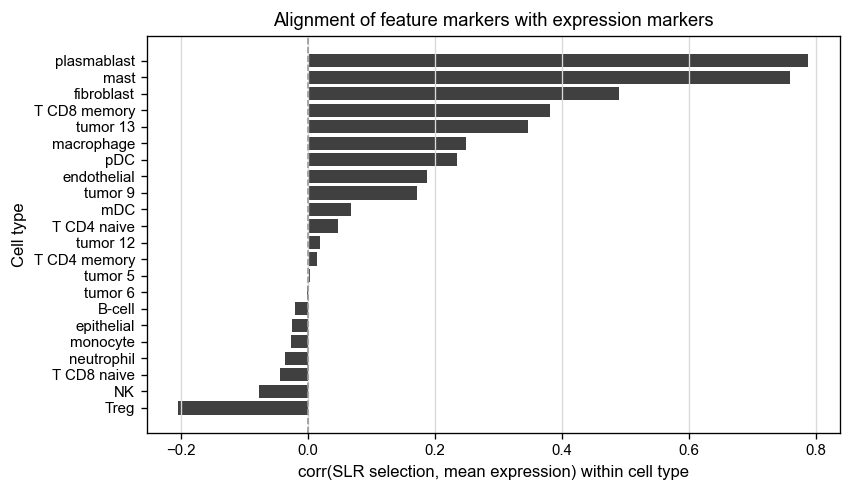

=== FigB ===
Saved: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/final_figures_for_fts_markers/figB_corr_vs_variance.pdf


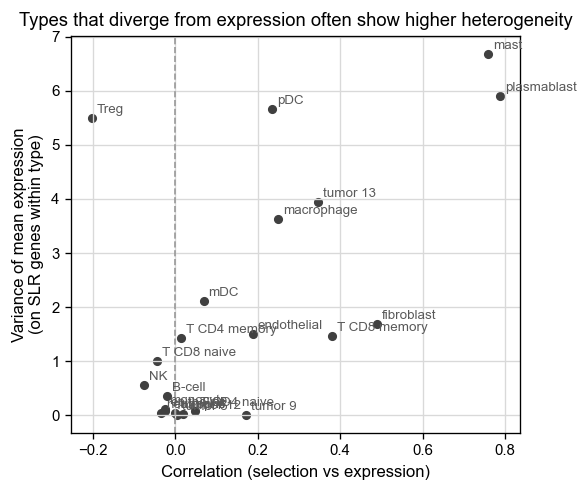

=== FigC ===
Saved: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/final_figures_for_fts_markers/figC_overlap_heatmap.pdf


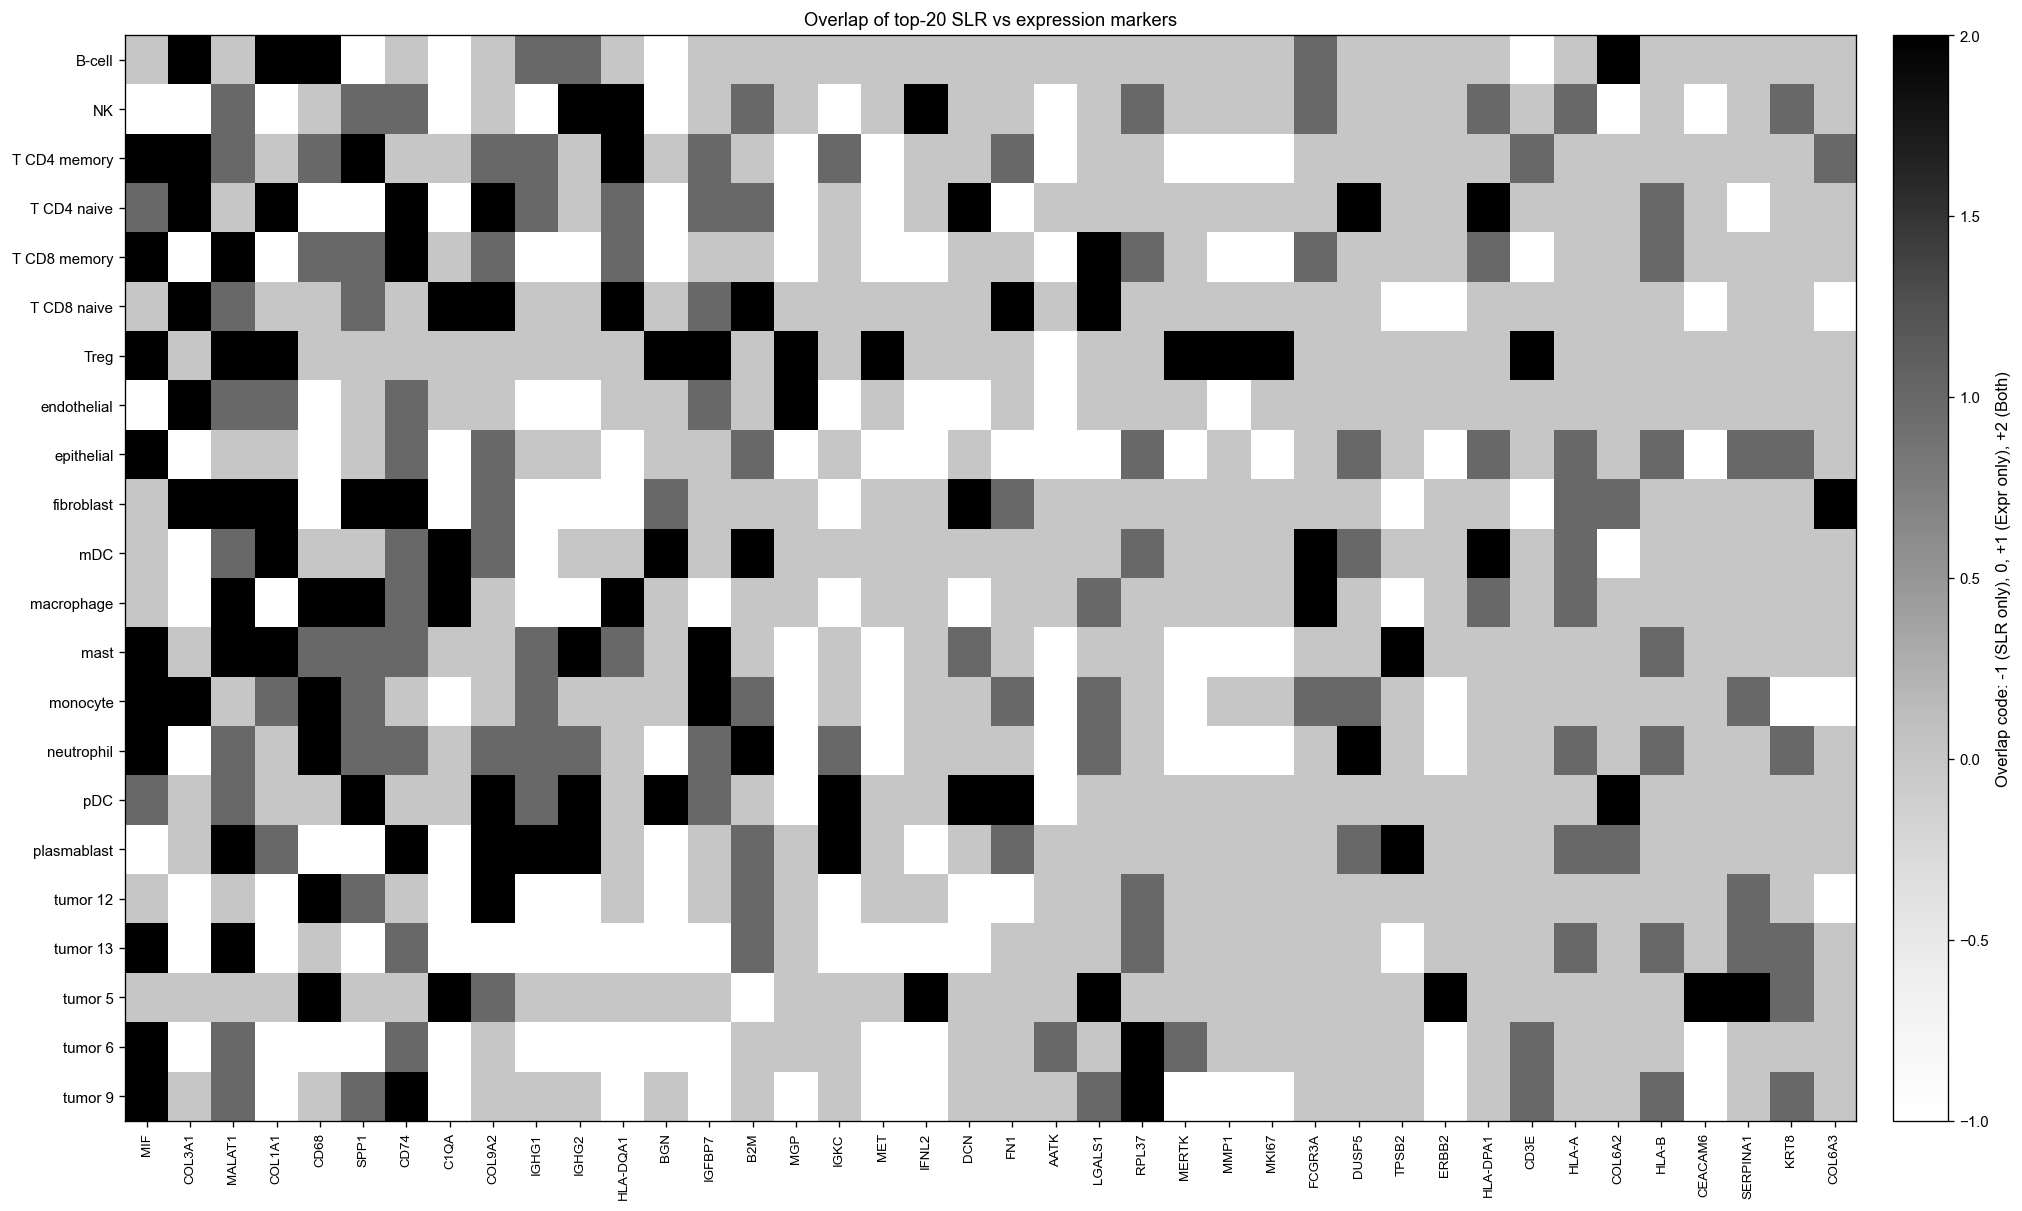

=== FigD ===
Saved: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/final_figures_for_fts_markers/figD_feature_vs_expr_neuron2963.pdf


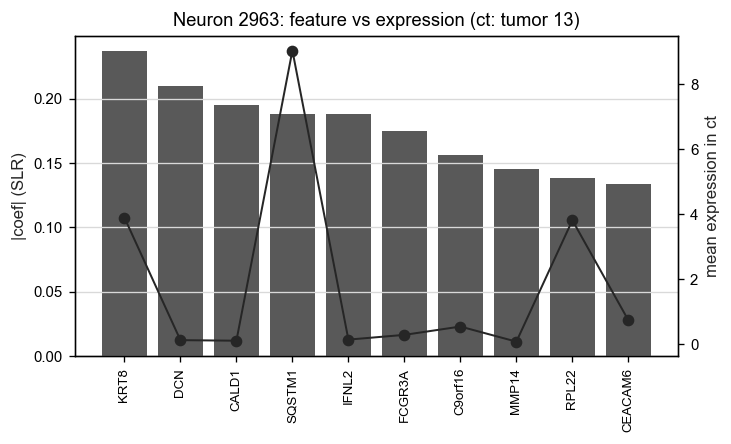

Saved: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/final_figures_for_fts_markers/figD_feature_vs_expr_neuron3039.pdf


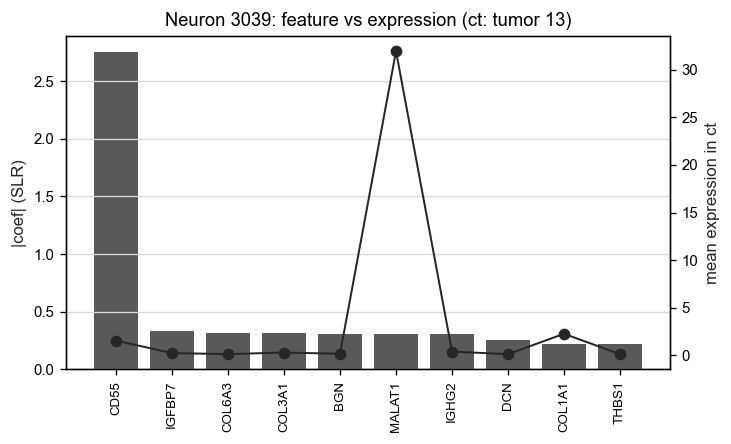

Saved: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/final_figures_for_fts_markers/figD_feature_vs_expr_neuron34.pdf


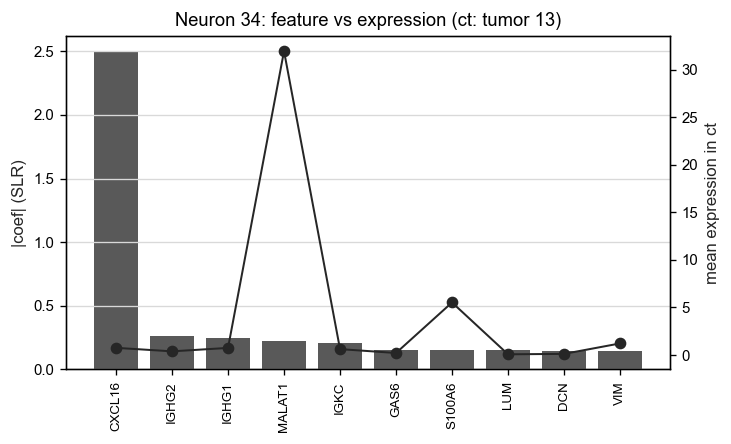

=== FigE ===


/tmp/ipykernel_364657/850189113.py:281: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Saved: /maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/targets_related/final_figures_for_fts_markers/figE_enrichment_heatmap.pdf


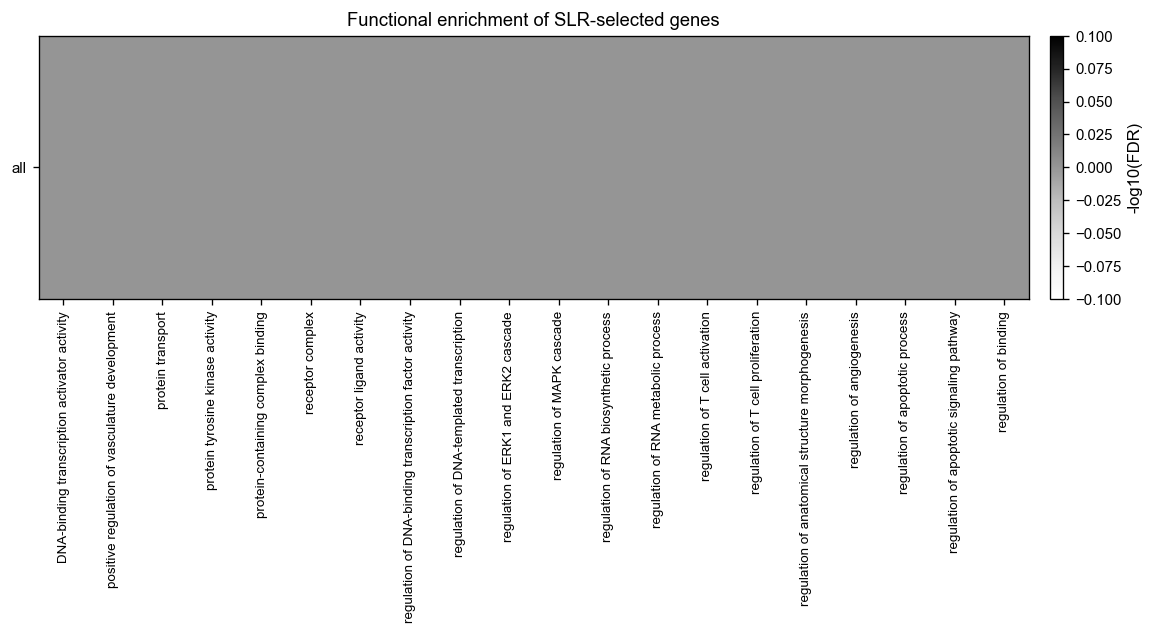

In [13]:
# If you ran my figure kit cell earlier, just call:
make_all_figures_A_to_E(
    adata=adata,
    H_SAE=H_SAE,
    CELLTYPE_TOKEN=CELLTYPE_TOKEN,
    cell_idx_token=cell_idx_token,
    logit_df=logit_df,
    cor_df=cor_df,
    joined=joined,        # the cell_type×gene table used to compute cor_df
    gene_sets=gene_sets,  # optional for FigE; pass None to skip
    agg="max"
)